# The RTI model - V 6.0

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from numba import jit
import collections
import pickle
import time
from multiprocessing import Pool

### Parameters and tables

In [2]:
num_reps = 1

year = 2019

population_size = 1000

initial_age_RTI = 30
Age_30_Demographics = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "Age 30 Demographics")

Proteinuria_Incidence = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "Proteinuria Incidence", index_col=[0,1])
Diabetes_Incidence = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "Diabetes Incidence", index_col=[0,1])
Hypertension_presence = (pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "SBP Prevalence", index_col=[0,1,2]) >= 140).sort_index()
Anemia_Incidence = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "Anemia Incidence", index_col=[0,1,2,3])

COSTS_discounted = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "COSTS-2006", index_col=[0]) * 1.27
COSTS_Smith_discounted = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "COSTS-Smith-2001", index_col=[0]) * 1.44

DALYs = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "DALYs", index_col=[0])

initial_eGFR_mu = 101.941
initial_eGFR_sigma = 19.313


All_Cause_Mortality_Rates = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "All Cause Mortality Rates", index_col=[0,1])
ESKD_Mortality_Rates = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "ESKD Mortality Rates", index_col=[0,1,2])
CKD_mortality_coefficient = pd.DataFrame({'No_CKD': 1.0, 'Stage_1': 1.0, 'Stage_2': 1.0, 'Stage_3a':1.2, 'Stage_3b':1.8, 'Stage_4':3.2, 'Stage_5':5.9}, index = [0])

Life_Expectancy = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "Life Expectancy", index_col=[0,1])

Awareness_CKD = pd.read_excel('CKD_RTI_2022_tables.xlsx', sheet_name = "Awareness_NHANES", index_col=[0,1])

##############################################################################################################

CUSUM_mu = 80.65
CUSUM_sigma = 7.78
w = 0.75
T = -4
CUSUM_initial = 0

CUSUM_specificity = 0.910
CUSUM_sensitivity = 0.830
CUSUM_accuracy = 0.76

treatment_adherence = 0.75
tretment_effect_eGFR = 0.673
tretment_effect_mortality = 0.77

##############################################################################################################

#uniques = []
#for item in list(np.unique(COSTS_breakdown_observations_CUSUM)):
#    uniques = uniques + item
    
#All_costs_titles = list(set(uniques))

All_costs_titles = ['Productivity_Loss',  'No_CKD',  'Anemia and Stage_5',  'Stage_3a',  'HBP and Stage_4',  'Stage_2', 'Initial visit',  'DM and Stage_4',  'DM and Stage_5', 'Confimatory DM or HBP',  'HBP and Stage_2',  'Stage_4',  'Anemia and Stage_4',  'Stage_1',  'Stage_3b',  'HBP and Stage_5',  'DM and Stage_3a',  'Anemia and Stage_3b',  'Proteinuria',  'Male',  'Anemia',  'DM and Stage_2',   'absent_present_cost_HBP',  'DM and Stage_3b',  'DM and Stage_1',  'HBP and Stage_1', 'ESKD_1',  'ESKD_2_on',  'HBP and Stage_3b',  'Anemia and Stage_3a', 'HBP and Stage_3a',   'Stage_5',  'absent_present_cost_DM']
All_costs_titles_CUSUM = ['Basic metabolic panel',  'Productivity_Loss',  'No_CKD',  'Anemia and Stage_5',  'Stage_3a',  'HBP and Stage_4',  'Stage_2',  'Second visit if first positive',  'Initial visit',  'DM and Stage_4',  'DM and Stage_5', 'Confimatory DM or HBP',  'HBP and Stage_2',  'Stage_4',  'Anemia and Stage_4',  'Stage_1',  'Stage_3b',  'HBP and Stage_5',  'DM and Stage_3a',  'Anemia and Stage_3b',  'Proteinuria',  'Male',  'Anemia',  'DM and Stage_2',  'Confimatory Proteinuria',  'absent_present_cost_HBP',  'DM and Stage_3b',  'DM and Stage_1',  'HBP and Stage_1',  'Confimatory No Complications',  'ESKD_1',  'ESKD_2_on',  'HBP and Stage_3b',  'Anemia and Stage_3a', 'HBP and Stage_3a',   'Stage_5',  'absent_present_cost_DM']

### get_CKD_stage(eGFR, proteinuria_status)

In [3]:
def get_CKD_stage(eGFR, proteinuria_status):
    
    if eGFR >= 120:
        return('No_CKD')
    
    if (eGFR >= 90) & (eGFR < 120) :
        if proteinuria_status:
            return('Stage_1')
        else:
            return('No_CKD')
        
    if (eGFR >= 60) & (eGFR < 90):
        if proteinuria_status:
            return('Stage_2')
        else:
            return('No_CKD')
    
    if (eGFR >= 45) & (eGFR < 60):
        return('Stage_3a')
    
    if (eGFR >= 30) & (eGFR < 45):
        return('Stage_3b')
    
    if (eGFR >= 15) & (eGFR < 30):
        return('Stage_4')
    
    if (eGFR < 15):
        return('Stage_5')

### get_diabetes(race, gender, age, diabetes_status)

In [4]:
def get_diabetes(race, gender, age, diabetes_status):
    
    if diabetes_status:
        return(True)
    
    else:
        diabetes_probability = Diabetes_Incidence.loc[(race, gender)][age]
        rand = np.random.random()

        if rand <= diabetes_probability:
            return(True)
        else:
            return(False)      

### get_hypertension_history(gender)

In [5]:
def get_hypertension_history(gender):
    
    #CKD_stage == 'No_CKD' or 'CKD'
        
    rand = np.random.normal(0,1)
    if rand >= 1.644853:
        indexx = 8
    else:
        indexx = pd.Series(rand < Hypertension_presence.loc[('CKD', gender)].index.values)[pd.Series(rand < Hypertension_presence.loc[('CKD', gender)].index.values)].index[0]
        
    hypertension_history_CKD = Hypertension_presence.loc[('CKD', gender, Hypertension_presence.loc[('CKD', gender)].index[indexx])].values    
    hypertension_history_NoCKD = Hypertension_presence.loc[('No_CKD', gender, Hypertension_presence.loc[('No_CKD', gender)].index[indexx])].values    
    
    hypertension_history = [list(hypertension_history_NoCKD), list(hypertension_history_CKD)]
    
    return(hypertension_history)

### get_hypertension(age, CKD_stage, *hypertension_history)

In [6]:
def get_hypertension(age, CKD_stage, *hypertension_history):

    if CKD_stage == 'No_CKD':
        return(hypertension_history[0][int(age)-30])
    else:
        return(hypertension_history[1][int(age)-30])    

### get_proteinuria(diabetes_status, hypertension_status, gender, age, proteinuria_status)

In [7]:
def get_proteinuria(diabetes_status, hypertension_status, gender, age, proteinuria_status):
    
    if proteinuria_status:
        return(True)
    
    else:
        rand = np.random.random()

        if (diabetes_status) & (hypertension_status == False):
            proteinuria_probability = Proteinuria_Incidence.loc[('Diabetes', gender)][age]   
        elif (hypertension_status) & (diabetes_status == False):
            proteinuria_probability = Proteinuria_Incidence.loc[('Hypertension', gender)][age]
        elif (hypertension_status) & (diabetes_status):
            proteinuria_probability = max(Proteinuria_Incidence.loc[('Hypertension', gender)][age], Proteinuria_Incidence.loc[('Diabetes', gender)][age])  
        else:
            proteinuria_probability = Proteinuria_Incidence.loc[('Neither', gender)][age]

        if rand <= proteinuria_probability:
            return(True)
        else:
            return(False)

### get_anemia(race, gender, age, diabetes_status, CKD_stage, anemia_status)

In [8]:
def get_anemia(race, gender, age, diabetes_status, CKD_stage, anemia_status):
    
    if anemia_status:
        return(True)
    
    else:        
        if (CKD_stage == 'No_CKD') | (CKD_stage == 'Stage_1') | (CKD_stage == 'Stage_2'):
            return(False)
        else:
            rand = np.random.random()

            if diabetes_status == True:
                anemia_probability = Anemia_Incidence.loc[(CKD_stage, gender, race, 'Diabetes')][age]
            else:
                anemia_probability = Anemia_Incidence.loc[(CKD_stage, gender, race, 'Neither')][age]

            if rand <= anemia_probability:
                return(True)
            else:
                return(False) 

### get_living_status(diabetes_status, hypertension_status, CKD_stage, age, race, gender, living_status)

In [9]:
def get_living_status(diabetes_status, hypertension_status, CKD_stage, age, race, gender, living_status, mortality_reduction_rate = 1):
    
    if living_status == False:
        return(False)
    
    else:
        rand = np.random.random()

        if (CKD_stage == 'No_CKD') | (CKD_stage == 'Stage_1') | (CKD_stage == 'Stage_2') | (CKD_stage == 'Stage_3a') | (CKD_stage == 'Stage_3b') | (CKD_stage == 'Stage_4')  | (CKD_stage == 'Stage_5'):

            mortality_probability = All_Cause_Mortality_Rates.loc[(race, gender)][age] * CKD_mortality_coefficient[CKD_stage].values[0] * mortality_reduction_rate
            
            if rand <= mortality_probability:
                return(False)
            else:
                return(True) 
        else:
                
            if (diabetes_status) & (hypertension_status == False):
                mortality_probability = ESKD_Mortality_Rates.loc[(race, 'Diabetes', gender)][age] * mortality_reduction_rate   
            elif (hypertension_status) & (diabetes_status == False):
                mortality_probability = ESKD_Mortality_Rates.loc[(race, 'Hypertension', gender)][age] * mortality_reduction_rate
            elif (hypertension_status) & (diabetes_status):
                mortality_probability = max(ESKD_Mortality_Rates.loc[(race, 'Diabetes', gender)][age] * mortality_reduction_rate, ESKD_Mortality_Rates.loc[(race, 'Hypertension', gender)][age] * mortality_reduction_rate)  
            else:
                mortality_probability = ESKD_Mortality_Rates.loc[(race, 'Neither', gender)][age] * mortality_reduction_rate
        
            if rand <= mortality_probability:
                return(False)
            else:
                return(True)

### get_COSTS(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status): #age is omitted so far

In [10]:
def get_COSTS(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status): #age is omitted so far

    final_cost = 0
    
    if CKD_stage != 'Deceased': #if alive:
        final_cost = final_cost + COSTS_Smith_discounted.loc['No_CKD':'ESKD_2_on', 'Cost'][CKD_stage]        
        
        if gender == 'Male':
            
            final_cost = final_cost + COSTS_Smith_discounted.loc['Male']['Cost']
            
        if diabetes_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Diabetes']['Cost'] + absent_present_cost_DM_discounted
            
            if CKD_stage in ['Stage_1', 'Stage_2', 'Stage_3a', 'Stage_3b', 'Stage_4', 'Stage_5']:
                final_cost = final_cost + COSTS_Smith_discounted.loc['Diabetes'][CKD_stage] 
            
        if hypertension_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Hypertension']['Cost'] + absent_present_cost_HBP_discounted
            
            if CKD_stage in ['Stage_1', 'Stage_2', 'Stage_3a', 'Stage_3b', 'Stage_4', 'Stage_5']:
                final_cost = final_cost + COSTS_Smith_discounted.loc['Hypertension'][CKD_stage] 
                
        if anemia_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Anemia']['Cost']
            if CKD_stage in ['Stage_1', 'Stage_2', 'Stage_3a', 'Stage_3b', 'Stage_4', 'Stage_5']:
                final_cost = final_cost + COSTS_Smith_discounted.loc['Anemia'][CKD_stage] 
                
        if proteinuria_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Proteinuria']['Cost'] 

    return(final_cost)

In [11]:
def get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status): #age is omitted so far
    
    cost_breakdown = []
    final_cost = 0
    
    if CKD_stage != 'Deceased': #if alive:
        final_cost = final_cost + COSTS_Smith_discounted.loc['No_CKD':'ESKD_2_on', 'Cost'][CKD_stage]        
        cost_breakdown.append(CKD_stage)
        
        if gender == 'Male':
            
            final_cost = final_cost + COSTS_Smith_discounted.loc['Male']['Cost']
            cost_breakdown.append(gender)
            
        if diabetes_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Diabetes']['Cost']
            cost_breakdown.append('Diabetes')
            
            if CKD_stage in ['Stage_1', 'Stage_2', 'Stage_3a', 'Stage_3b', 'Stage_4', 'Stage_5']:
                final_cost = final_cost + COSTS_Smith_discounted.loc['Diabetes'][CKD_stage] 
                cost_breakdown.append('DM and {}'.format(CKD_stage))
            
        if hypertension_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Hypertension']['Cost']
            cost_breakdown.append('Hypertension')
            
            if CKD_stage in ['Stage_1', 'Stage_2', 'Stage_3a', 'Stage_3b', 'Stage_4', 'Stage_5']:
                final_cost = final_cost + COSTS_Smith_discounted.loc['Hypertension'][CKD_stage] 
                cost_breakdown.append('HBP and {}'.format(CKD_stage))
                
        if anemia_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Anemia']['Cost']
            cost_breakdown.append('Anemia')
            
            if CKD_stage in ['Stage_1', 'Stage_2', 'Stage_3a', 'Stage_3b', 'Stage_4', 'Stage_5']:
                final_cost = final_cost + COSTS_Smith_discounted.loc['Anemia'][CKD_stage] 
                cost_breakdown.append('Anemia and {}'.format(CKD_stage))
                
        if proteinuria_status:

            final_cost = final_cost + COSTS_Smith_discounted.loc['Proteinuria']['Cost'] 
            cost_breakdown.append('Proteinuria')

    return([final_cost, cost_breakdown])

### get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)

In [12]:
def get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status):
    
    if CKD_stage != 'Deceased': #if alive:
        if anemia_status:
            DALY = DALYs.loc[CKD_stage]['Anemia (avg)']
        else:
            DALY = DALYs.loc[CKD_stage]['No Anemia']
    
    else: #if deceased:
        life_exp = np.round(Life_Expectancy.loc[(race, gender)][death_age])
        
        if age < death_age + life_exp:
            DALY = 1.0
        else:
            DALY = 0.0

    return(DALY)

### get_QALYs(CKD_stage)

In [13]:
QALYS = pd.DataFrame({'No_CKD': [1], 'Stage_1': [1], 'Stage_2': [0.85], 'Stage_3a': [0.80], 'Stage_3b': [0.80], 'Stage_4': [0.74], 'Stage_5': [0.73], 'ESKD_1': [0.64], 'ESKD_2_on':[0.64], 'Deceased': [0]})

# resource:https://hqlo.biomedcentral.com/articles/10.1186/s12955-020-01559-x 
# we picked the highest values reported to have acted conservetively 

def get_QALYs(CKD_stage):
        
    QALY = QALYS[CKD_stage][0]
    
    return(QALY)

### get_CUSUM_statistic(eGFR, CUSUM_i_1):

In [14]:
def get_CUSUM_statistic(eGFR, CUSUM_t_1):
    
    CUSUM_t = np.min([0, (eGFR - CUSUM_mu)/CUSUM_sigma + w + CUSUM_t_1])
    
    return(CUSUM_t)

### get_CUSUM_age_adjusted_statistic(age, eGFR, CUSUM_t_1):

In [15]:
def get_CUSUM_age_adjusted_statistic(age, eGFR, CUSUM_t_1):

    #age >= 31
    CUSUM_t = np.min([0, (eGFR - ((86.6994835513837 + 88.80908753375147)/2 - 0.81 * (age - 30)))/CUSUM_sigma + w + CUSUM_t_1])
    
    return(CUSUM_t)

### get_CUSUM_statistic_w_coef(eGFR, CUSUM_i_1, w_coef):

In [16]:
def get_CUSUM_statistic_w_coef(eGFR, CUSUM_t_1, w_coef):
    
    CUSUM_t = np.min([0, (eGFR - CUSUM_mu)/CUSUM_sigma + w * w_coef + CUSUM_t_1])
    
    return(CUSUM_t)

### get_CUSUM_confirmatory_test_costs(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status)

In [17]:
def get_CUSUM_confirmatory_test_costs_RTI(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status):
    
    confirmatory_test_costs = COSTS_discounted.loc['Second visit if first positive']['Costs']
    
    if diabetes_status | hypertension_status:
        confirmatory_test_costs = confirmatory_test_costs + 346.74*1.27
        
    if (diabetes_status == False) & (hypertension_status == False) & (proteinuria_status == False):
        confirmatory_test_costs = confirmatory_test_costs + 1000*1.27  ##### REY ASSYMPTION
        
    if proteinuria_status:
        if CUSUM_signal_age < 65:
            confirmatory_test_costs = confirmatory_test_costs + 2590.57*1.27 #assumign the most expensive one!
        else:
            confirmatory_test_costs = confirmatory_test_costs + 874.70*1.27
    return(confirmatory_test_costs)

In [18]:
def get_CUSUM_confirmatory_test_costs_RTI_breakdown(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status):
    
    cost_breakdown = []
    confirmatory_test_costs = COSTS_discounted.loc['Second visit if first positive']['Costs']
    
    cost_breakdown.append('Second visit if first positive')
    
    if diabetes_status | hypertension_status:
        confirmatory_test_costs = confirmatory_test_costs + 346.74*1.27
        
        cost_breakdown.append('Confimatory DM or HBP')
        
    if (diabetes_status == False) & (hypertension_status == False) & (proteinuria_status == False):
        confirmatory_test_costs = confirmatory_test_costs + 1000*1.27  ##### REY ASSYMPTION
        
        cost_breakdown.append('Confimatory No Complications')
        
    if proteinuria_status:
        if CUSUM_signal_age < 65:
            confirmatory_test_costs = confirmatory_test_costs + 2590.57*1.27 #assumign the most expensive one!
        else:
            confirmatory_test_costs = confirmatory_test_costs + 874.70*1.27
        cost_breakdown.append('Confimatory Proteinuria')
    return([confirmatory_test_costs, cost_breakdown])

### get_CUSUM_treatment_costs(eGFR, diabetes_status, hypertension_status, proteinuria_status)

In [19]:
def get_CUSUM_treatment_costs(eGFR, diabetes_status, hypertension_status, proteinuria_status):
    
    treatment_costs = 0
    
    if proteinuria_status | hypertension_status:
        if diabetes_status:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Drug therapy - ARB']['Costs']
            
        else: #they already have proteinuria so they are eligible to recieve medication.

            treatment_costs = treatment_costs + COSTS_discounted.loc['Drug therapy - ACE']['Costs']
    else:
        if diabetes_status == False:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Annual generalist visits (3)']['Costs']
            
    if eGFR < 60:
        if diabetes_status:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Annual specialist follow-up (eGFR < 60) - DM']['Costs']
        else:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Annual specialist follow-up (eGFR < 60) - No DM']['Costs']        
        
    return(treatment_costs)    

In [20]:
def get_CUSUM_treatment_costs_breakdown(eGFR, diabetes_status, hypertension_status, proteinuria_status):
    
    treatment_costs = 0
    cost_breakdown = []
    
    if proteinuria_status | hypertension_status:
        if diabetes_status:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Drug therapy - ARB']['Costs']
            cost_breakdown.append('Drug therapy - ARB')
            
        else: #they already have proteinuria so they are eligible to recieve medication.

            treatment_costs = treatment_costs + COSTS_discounted.loc['Drug therapy - ACE']['Costs']
            cost_breakdown.append('Drug therapy - ACE')
    else:
        if diabetes_status == False:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Annual generalist visits (3)']['Costs']
            cost_breakdown.append('Annual generalist visits (3)')
            
    if eGFR < 60:
        if diabetes_status:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Annual specialist follow-up (eGFR < 60) - DM']['Costs']
            cost_breakdown.append('Annual specialist follow-up (eGFR < 60) - DM')
        else:
            treatment_costs = treatment_costs + COSTS_discounted.loc['Annual specialist follow-up (eGFR < 60) - No DM']['Costs']
            cost_breakdown.append('Annual specialist follow-up (eGFR < 60) - No DM')

        
    return([treatment_costs, cost_breakdown])    

### Initializing the model: get_patient(sid)

In [21]:
def get_patient(sid):
    
    np.random.seed(sid)
    random.seed(sid*2)
    
    living_status = True #They are alive!
    initial_age = initial_age_RTI
    [race, gender] = random.choices([['White', 'Male'], ['Black', 'Male'], ['Hispanic', 'Male'], ['White', 'Female'], ['Black', 'Female'], ['Hispanic', 'Female']], k = 1, weights = [0.36522, 0.06045, 0.07758, 0.35729, 0.06723, 0.07224])[0]
    
    initial_eGFR = np.random.normal(initial_eGFR_mu, initial_eGFR_sigma)
    eGFR_decline_random_coeff = np.random.triangular(0,1,2)
    
    initial_anemia_status = False
    initial_CKD_stage = 'No_CKD' #assuming no one has CKD stages in the beginning, or if they do we just dont consider it in calculating the blood pressure
    initial_diabetes_status = get_diabetes(race, gender, initial_age, False) #True or False
    initial_hypertension_history = get_hypertension_history(gender) #an array of Trues and Falses
    initial_hypertension_status = get_hypertension(initial_age, initial_CKD_stage, *initial_hypertension_history)
    initial_proteinuria_status = get_proteinuria(initial_diabetes_status, initial_hypertension_status, gender, initial_age, False) #True or False
    
    new_row = {'patient_id':sid, 'living_status':living_status, 'race':race, 'gender':gender, 'initial_age':initial_age_RTI, 'initial_eGFR':initial_eGFR, 'eGFR_decline_random_coeff':eGFR_decline_random_coeff, 'initial_CKD_stage':initial_CKD_stage, 'initial_diabetes_status':initial_diabetes_status, 'initial_hypertension_history':initial_hypertension_history,  'initial_hypertension_status':initial_hypertension_status, 'initial_proteinuria_status':initial_proteinuria_status, 'initial_anemia_status':initial_anemia_status}
    return(new_row)

# ________________________________________________________________________________________________________________

# Base Scenario : modeling natural progression of CKD among 1000 patients

In [22]:
def create_base_scenario(j):

    Patients_List = pd.DataFrame({'patient_id':[], 'living_status':[], 'race':[], 'gender':[], 'initial_age':[],'initial_eGFR':[], 'eGFR_decline_random_coeff': [], 'initial_CKD_stage':[], 'initial_diabetes_status':[], 'initial_hypertension_history':[], 'initial_hypertension_status':[], 'initial_proteinuria_status':[], 'initial_anemia_status':[]}).astype(bool)

    for sid in range(population_size + 1):

        patient = get_patient(sid + j*99999)
        Patients_List = Patients_List.append(patient, ignore_index=True)

    Patients_List = Patients_List.drop([0], axis = 0).reset_index(drop=True) #because the first row does not show True or False! idk why! it showes 0.0 or 1.1! so we drop it :)
    Patients_List['patient_id'] = Patients_List['patient_id'].astype(int)
    
#___________________________________________________________________________________________________________________________________________________________________________________________

    COSTS_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    COSTS_breakdown_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    DALYS_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    QALYS_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)

    death_age_list = []

    for index, patient in Patients_List.iterrows():

        living_status = patient.living_status
        race = patient.race
        gender = patient.gender

        eGFR_decline_random_coeff = patient.eGFR_decline_random_coeff

        CKD_stage = patient.initial_CKD_stage
        diabetes_status = patient.initial_diabetes_status 
        hypertension_history = patient.initial_hypertension_history
        hypertension_status = patient.initial_hypertension_status
        proteinuria_status = patient.initial_proteinuria_status 
        anemia_status = patient.initial_anemia_status 

        eGFR = patient.initial_eGFR
        age = patient.initial_age

        stage_5_flag = 0
        death_age = 0

        costs_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0]]
        costs_breakdown_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1]]
        DALYs_list = [get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)]
        QALYs_list = [get_QALYs(CKD_stage)]

        for t in range(31, 91):

    #eGFR decline rate

            if diabetes_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 4.1
                    else:
                        eGFR_decrement = 5.2
                else:
                    if eGFR < 60:
                        eGFR_decrement = 1.1
                    else:
                        eGFR_decrement = 2.8

            if hypertension_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.784
                    else:
                        eGFR_decrement = 3.9
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.719
                    else:
                        eGFR_decrement = 1.4

            if ((hypertension_status) == False) & (diabetes_status == False):
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.719
                    else:
                        eGFR_decrement = 4.2
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.653
                    else:
                        eGFR_decrement = 0.653

    # Now, actually doing the thing

        #first, check if they are alive!

            if living_status == True:

                eGFR = eGFR - eGFR_decrement*eGFR_decline_random_coeff
                age = age + 1

                diabetes_status = get_diabetes(race, gender, age, diabetes_status)        
                hypertension_status = get_hypertension(age, CKD_stage, *hypertension_history)
                proteinuria_status = get_proteinuria(diabetes_status, hypertension_status, gender, age, proteinuria_status)
                CKD_stage = get_CKD_stage(eGFR, proteinuria_status)
                anemia_status = get_anemia(race, gender, age, diabetes_status, CKD_stage, anemia_status)

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 2):
                    CKD_stage = 'ESKD_2_on'

                if(CKD_stage == 'Stage_5') & (stage_5_flag == 1):
                    CKD_stage = 'ESKD_1'
                    stage_5_flag = 2

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 0):
                    stage_5_flag = 1

            #But, whatif they die? :,(

                living_status = get_living_status(diabetes_status, hypertension_status, CKD_stage, age, race, gender, living_status, 1)

                if living_status == False:    

                    death_age = age
                    death_age_list.append(death_age)

                    eGFR = 0

                    diabetes_status = False
                    hypertension_status = False
                    proteinuria_status = False
                    CKD_stage = 'Deceased'
                    anemia_status = False

            else: #if already not alive:

                eGFR = 0
                age = age + 1

                diabetes_status = False
                hypertension_status = False
                proteinuria_status = False
                CKD_stage = 'Deceased'
                anemia_status = False


    ###### C.O.S.T.S.!!! ######

            cost_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0]
            cost_breakdown_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1]

     ###### D.A.L.Y.S.!!! ###### and  ###### Q.A.L.Y.S.!!! ######

            DALY_step = get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)
            QALY_step = get_QALYs(CKD_stage)


         #putting together everything!

            costs_list.append(cost_step)
            costs_breakdown_list.append(cost_breakdown_step)
            DALYs_list.append(DALY_step)
            QALYs_list.append(QALY_step)

        COSTS_observations = COSTS_observations.append(pd.Series(costs_list, index = COSTS_observations.columns[:len(costs_list)]), ignore_index = True)
        COSTS_breakdown_observations = COSTS_breakdown_observations.append(pd.Series(costs_breakdown_list, index = COSTS_breakdown_observations.columns[:len(costs_breakdown_list)]), ignore_index = True)
        DALYS_observations = DALYS_observations.append(pd.Series(DALYs_list, index = DALYS_observations.columns[:len(DALYs_list)]), ignore_index = True)
        QALYS_observations = QALYS_observations.append(pd.Series(QALYs_list, index = QALYS_observations.columns[:len(QALYs_list)]), ignore_index = True)

#___________________________________________________________________________________________________________________________________________________________________________________________

        if death_age == 0:
            death_age = np.NaN
            death_age_list.append(death_age)

    Patients_List['age_of_death_no_screening'] = death_age_list
#___________________________________________________________________________________________________________________________________________________________________________________________

#DALYs

    final_col = 0
    for col in DALYS_observations.columns:
        final_col = final_col + DALYS_observations[col]/((1+0.03)**(col-30))

    Total_DALYs = np.sum(final_col)

    #QALYs

    final_col = 0
    for col in QALYS_observations.columns:
        final_col = final_col + QALYS_observations[col]/((1+0.03)**(col-30))

    Total_QALYs = np.sum(final_col)
    
    #Costs

    final_col = 0
    for col in COSTS_observations.columns:
        final_col = final_col + COSTS_observations[col]/((1+0.03)**(col-30))

    Total_costs = np.sum(final_col)

#___________________________________________________________________________________________________________________________________________________________________________________________

    return([Patients_List, COSTS_observations, DALYS_observations, Total_DALYs, QALYS_observations, Total_QALYs, Total_costs, COSTS_breakdown_observations])

In [ ]:
with open("Base_Scenario_Patients_rep.txt", "rb") as fp:   #Pickling
    Patients_rep = pickle.load(fp)

with open("Base_Scenario_costs_steps_rep.txt", "rb") as fp:   #Pickling
    costs_steps_rep = pickle.load(fp)
    
with open("Base_Scenario_dalys_steps_rep.txt", "rb") as fp:   #Pickling
    dalys_steps_rep = pickle.load(fp)
    
with open("Base_Scenario_DALYS_rep.txt", "rb") as fp:   #Pickling
    DALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_qalys_steps_rep.txt", "rb") as fp:   #Pickling
    qalys_steps_rep = pickle.load(fp)
    
with open("Base_Scenario_QALYS_rep.txt", "rb") as fp:   #Pickling
    QALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_COSTS_rep.txt", "rb") as fp:   #Pickling
    COSTS_rep = pickle.load(fp)

with open("Base_Scenario_costs_breakdown_rep.txt", "rb") as fp:   #Pickling
    costs_breakdown_rep = pickle.load(fp)

In [ ]:
lius_YLLs = []
lius_YLDs = []

for i in range(num_reps):    

    lius_YLLs.append(dalys_steps_rep[i][dalys_steps_rep[i] ==1].fillna(0))
    lius_YLDs.append(dalys_steps_rep[i][dalys_steps_rep[i] < 1].fillna(0))
    
sum_YLLs = sum(lius_YLLs)
sum_YLDs = sum(lius_YLDs)

final_col = 0
for col in sum_YLLs.columns:
    final_col = final_col + sum_YLLs[col]/((1+0.03)**(col-30))
Total_DALYs_YLLs = np.sum(final_col)

final_col = 0
for col in sum_YLLs.columns:
    final_col = final_col + sum_YLDs[col]/((1+0.03)**(col-30))
Total_DALYs_YLDs = np.sum(final_col)

print('YLLs: ', Total_DALYs_YLLs/(1000*num_reps))
print('YLDs: ', Total_DALYs_YLDs/(1000*num_reps))

# Scenario #2 : Universal screening for everyone, starting age 30, biannually. (at least 2 obs)

In [ ]:
#def get_scenario_2(j, [Patients_List, COSTS_observations, DALYS_observations, Total_DALYs, Total_costs, COSTS_breakdown_observations]):
def get_scenario_2(Patients_List, COSTS_observations, DALYS_observations, Total_DALYs, QALYS_observations, Total_QALYs, Total_costs, COSTS_breakdown_observations):

    # Universal screening for everyone, starting age 30, biannually

    
    test_count = 0
    No_CKD_but_positive_count = 0

    COSTS_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    COSTS_breakdown_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    DALYS_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    QALYS_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    
    test_count = 0
    No_CKD_but_positive_count = 0
    
    death_age_list = []

    for index, patient in Patients_List.iterrows():

        living_status = patient.living_status
        race = patient.race
        gender = patient.gender

        eGFR_decline_random_coeff = patient.eGFR_decline_random_coeff

        CKD_stage = patient.initial_CKD_stage
        diabetes_status = patient.initial_diabetes_status 
        hypertension_history = patient.initial_hypertension_history
        hypertension_status = patient.initial_hypertension_status
        proteinuria_status = patient.initial_proteinuria_status 
        anemia_status = patient.initial_anemia_status 

        eGFR = patient.initial_eGFR
        age = patient.initial_age

        CUSUM_test_flag = False
        CUSUM_confirmatory_test_flag = False
        CUSUM_treatment_flag = False
        individual_eGFR_test_count = 1

        CUSUM_signal_age = 0
        CUSUM_signal_eGFR = 0
        CUSUM_t = CUSUM_initial

        treatment_adherence = 0.75 

        eGFR_decrement_reduction_rate  = 1
        mortality_reduction_rate = 1

        stage_5_flag = 0
        death_age = 0

        costs_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0] + COSTS_discounted.loc[['Initial visit','Basic metabolic panel']]['Costs'].values.sum()]
        costs_breakdown_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1] + ['Initial visit','Basic metabolic panel']]
 
        DALYs_list = [get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)]
        QALYs_list = [get_QALYs(CKD_stage)]

        for t in range(31, 91):

    #eGFR decline rate

            if diabetes_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 4.1 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 5.2 * eGFR_decrement_reduction_rate
                else:
                    if eGFR < 60:
                        eGFR_decrement = 1.1 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 2.8 * eGFR_decrement_reduction_rate

            if hypertension_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.784 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 3.9 * eGFR_decrement_reduction_rate
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.719 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 1.4 * eGFR_decrement_reduction_rate

            if ((hypertension_status) == False) & (diabetes_status == False):
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.719 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 4.2 * eGFR_decrement_reduction_rate
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.653 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 0.653 * eGFR_decrement_reduction_rate

    # Now, actually doing the thing

        #first, check if they are alive!
            if living_status == True:

                eGFR = eGFR - eGFR_decrement*eGFR_decline_random_coeff
                age = age + 1

                diabetes_status = get_diabetes(race, gender, age, diabetes_status)        
                hypertension_status = get_hypertension(age, CKD_stage, *hypertension_history)
                proteinuria_status = get_proteinuria(diabetes_status, hypertension_status, gender, age, proteinuria_status)
                CKD_stage = get_CKD_stage(eGFR, proteinuria_status)
                anemia_status = get_anemia(race, gender, age, diabetes_status, CKD_stage, anemia_status)

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 2):
                    CKD_stage = 'ESKD_2_on'

                if(CKD_stage == 'Stage_5') & (stage_5_flag == 1):
                    CKD_stage = 'ESKD_1'
                    stage_5_flag = 2

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 0):
                    stage_5_flag = 1

            #But, whatif they die? :,(

                living_status = get_living_status(diabetes_status, hypertension_status, CKD_stage, age, race, gender, living_status, mortality_reduction_rate)

                if living_status == False:    

                    death_age = age
                    death_age_list.append(death_age)
                    
                    eGFR = 0

                    diabetes_status = False
                    hypertension_status = False
                    proteinuria_status = False
                    CKD_stage = 'Deceased'
                    anemia_status = False

    ####### C.U.S.U.M.!!! ###### _______________________________________________________________________________________________________________________________________________________

#  /\
# | |  Testing every 2 years!
# \/
                #starting at 50 years old, testing everyone biannually
                if (CUSUM_signal_age == 0) & (living_status) & (np.mod(age, 2) == 0) & (CKD_stage != 'ESKD_1') & (CKD_stage != 'ESKD_2_on'): #if no signal yet and alive yet (this at the end of the second year. They are 31 now, we have two EGFR observations)

                    CUSUM_t = get_CUSUM_age_adjusted_statistic(age, eGFR, CUSUM_t)
                    CUSUM_test_flag = True
                    test_count = test_count + 1
                    individual_eGFR_test_count = individual_eGFR_test_count + 1
                    
                    if (individual_eGFR_test_count > 3) & (CUSUM_t < T): # if signal:
                        
                        CUSUM_confirmatory_test_flag = True

                        CUSUM_signal_age = age   # So next time we will not test them at all!
                        CUSUM_signal_eGFR = eGFR

                        # No_CKD_but_positive_count

                        if CKD_stage == 'No_CKD':
                            No_CKD_but_positive_count = No_CKD_but_positive_count + 1

                        # awareness

                        patient_awareness_prob = Awareness_CKD.loc[(CKD_stage, race)]['Prevalence']

                        # treatment_eligibility_and_adherence_ACE_ARB

                        if proteinuria_status | hypertension_status:   #NHANES assumes this data comes from people who also have hypertension, but i do not. So just proteinuria is enough to recieve ACE/ARB
                            if diabetes_status:
                                treatment_eligibility_ACE_ARB_prob = 0.553
                            else:
                                treatment_eligibility_ACE_ARB_prob = 0.337

                            treatment_eligibility_awareness_prob = (1 - patient_awareness_prob) + (patient_awareness_prob)*(1 - treatment_eligibility_ACE_ARB_prob)  #not aware + aware and not receiving treatment


                        else:  #AAA WE assume Diabetic patients without HTN or PRTN do not receive ACE/ARB!!!!!!
                            treatment_eligibility_awareness_prob = 1


                        if np.random.random() <= treatment_adherence * treatment_eligibility_awareness_prob:

                            eGFR_decrement_reduction_rate = tretment_effect_eGFR
                            mortality_reduction_rate = tretment_effect_mortality

                            CUSUM_treatment_flag = True

    ########################### _______________________________________________________________________________________________________________________________________________________ 

            else: #if already not alive:

                eGFR = 0
                age = age + 1

                diabetes_status = False
                hypertension_status = False
                proteinuria_status = False
                CKD_stage = 'Deceased'
                anemia_status = False


    ###### C.O.S.T.S.!!! ######

            cost_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0]
            cost_breakdown_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1]

    #if CUSUM is negative:
            if CUSUM_test_flag & living_status:
                cost_step = cost_step + COSTS_discounted.loc[['Initial visit','Basic metabolic panel']]['Costs'].values.sum()
                cost_breakdown_step = cost_breakdown_step + ['Initial visit','Basic metabolic panel']
                CUSUM_test_flag = False

    #if CUSUM is positive:            
            if CUSUM_confirmatory_test_flag & living_status:  
            
                cost_step = cost_step + get_CUSUM_confirmatory_test_costs_RTI_breakdown(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status)[0]
                cost_breakdown_step = cost_breakdown_step + get_CUSUM_confirmatory_test_costs_RTI_breakdown(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status)[1]
                CUSUM_confirmatory_test_flag = False

            if CUSUM_treatment_flag & living_status: #if she dies, we dont add treatment costs no more!

                cost_step = cost_step + get_CUSUM_treatment_costs_breakdown(eGFR, diabetes_status, hypertension_status, proteinuria_status)[0]
                cost_breakdown_step = cost_breakdown_step + get_CUSUM_treatment_costs_breakdown(eGFR, diabetes_status, hypertension_status, proteinuria_status)[1]
            
    ###### D.A.L.Y.S.!!! ###### and  ###### Q.A.L.Y.S.!!! ######

            DALY_step = get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)
            QALY_step = get_QALYs(CKD_stage)


        # putting together everything!

            costs_list.append(cost_step)
            costs_breakdown_list.append(cost_breakdown_step)
            DALYs_list.append(DALY_step)
            QALYs_list.append(QALY_step)

        COSTS_observations_CUSUM = COSTS_observations_CUSUM.append(pd.Series(costs_list, index = COSTS_observations_CUSUM.columns[:len(costs_list)]), ignore_index = True)
        COSTS_breakdown_observations_CUSUM = COSTS_breakdown_observations_CUSUM.append(pd.Series(costs_breakdown_list, index = COSTS_breakdown_observations_CUSUM.columns[:len(costs_breakdown_list)]), ignore_index = True)
        DALYS_observations_CUSUM = DALYS_observations_CUSUM.append(pd.Series(DALYs_list, index = DALYS_observations_CUSUM.columns[:len(DALYs_list)]), ignore_index = True)
        QALYS_observations_CUSUM = QALYS_observations_CUSUM.append(pd.Series(QALYs_list, index = QALYS_observations_CUSUM.columns[:len(QALYs_list)]), ignore_index = True)
#___________________________________________________________________________________________________________________________________________________________________________________________

        if death_age == 0:
            death_age = np.NaN
            death_age_list.append(death_age)
            
    Patients_List['age_of_death_screening'] = death_age_list
#___________________________________________________________________________________________________________________________________________________________________________________________

    #DALYs

    final_col = 0
    for col in DALYS_observations_CUSUM.columns:
        final_col = final_col + DALYS_observations_CUSUM[col]/((1+0.03)**(col-30))

    Total_DALYs_CUSUM = np.sum(final_col)

    #QALYs

    final_col = 0
    for col in QALYS_observations_CUSUM.columns:
        final_col = final_col + QALYS_observations_CUSUM[col]/((1+0.03)**(col-30))

    Total_QALYs_CUSUM = np.sum(final_col)

    #Costs

    final_col = 0
    for col in COSTS_observations_CUSUM.columns:
        final_col = final_col + COSTS_observations_CUSUM[col]/((1+0.03)**(col-30))

    Total_costs_CUSUM = np.sum(final_col)

#___________________________________________________________________________________________________________________________________________________________________________________________

    # ICER

    ICER_value_DALYS = (Total_costs_CUSUM - Total_costs)/(Total_DALYs - Total_DALYs_CUSUM)
    ICER_value_QALYS = (Total_costs_CUSUM - Total_costs) / (Total_QALYs_CUSUM - Total_QALYs)
    
#___________________________________________________________________________________________________________________________________________________________________________________________
   
    
    return([COSTS_observations_CUSUM, DALYS_observations_CUSUM, Total_DALYs_CUSUM, QALYS_observations_CUSUM, Total_QALYs_CUSUM, Total_costs_CUSUM, ICER_value_DALYS, ICER_value_QALYS, test_count, No_CKD_but_positive_count, COSTS_breakdown_observations_CUSUM])


In [ ]:
import time
from multiprocessing import Pool

Patients_rep = []

costs_steps_rep = []
dalys_steps_rep = []
costs_steps_CUSUM_rep = []
dalys_steps_CUSUM_rep = []

costs_breakdown_rep = []
costs_breakdown_CUSUM_rep = []

DALYS_rep = []
COSTS_rep = []
DALYS_rep_CUSUM = []
COSTS_rep_CUSUM = []
ICERS_rep = []

test_count_list = []
No_CKD_but_positive_count_list = []

data = list(np.arange(num_reps))

p = Pool()
results = p.map(get_scenario_2, data)

for item in results:
    [Patients_List, COSTS_observations, DALYS_observations, COSTS_observations_CUSUM, DALYS_observations_CUSUM, Total_DALYs, Total_costs, Total_DALYs_CUSUM, Total_costs_CUSUM, ICER_value, test_count, No_CKD_but_positive_count, COSTS_breakdown_observations, COSTS_breakdown_observations_CUSUM] = item

    Patients_rep.append(Patients_List)
    costs_steps_rep.append(COSTS_observations)
    dalys_steps_rep.append(DALYS_observations)
    costs_steps_CUSUM_rep.append(COSTS_observations_CUSUM)
    dalys_steps_CUSUM_rep.append(DALYS_observations_CUSUM)

    DALYS_rep.append(Total_DALYs)
    COSTS_rep.append(Total_costs)
    DALYS_rep_CUSUM.append(Total_DALYs_CUSUM)
    COSTS_rep_CUSUM.append(Total_costs_CUSUM)
    ICERS_rep.append(ICER_value)

    test_count_list.append(test_count)
    No_CKD_but_positive_count_list.append(No_CKD_but_positive_count)

    costs_breakdown_rep.append(COSTS_breakdown_observations)
    costs_breakdown_CUSUM_rep.append(COSTS_breakdown_observations_CUSUM)

In [ ]:
with open("Base_Scenario_Patients_rep.txt", "rb") as fp:   #Pickling
    Patients_rep = pickle.load(fp)

with open("Base_Scenario_costs_steps_rep.txt", "rb") as fp:   #Pickling
    costs_steps_rep = pickle.load(fp)
    
with open("Base_Scenario_dalys_steps_rep.txt", "rb") as fp:   #Pickling
    dalys_steps_rep = pickle.load(fp)
    
with open("Base_Scenario_DALYS_rep.txt", "rb") as fp:   #Pickling
    DALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_COSTS_rep.txt", "rb") as fp:   #Pickling
    COSTS_rep = pickle.load(fp)

with open("Base_Scenario_costs_breakdown_rep.txt", "rb") as fp:   #Pickling
    costs_breakdown_rep = pickle.load(fp)


with open("Scenario_2_universal_biannual_30_costs_steps_CUSUM_rep.txt", "rb") as fp:   #Pickling
    costs_steps_CUSUM_rep = pickle.load(fp)

with open("Scenario_2_universal_biannual_30_dalys_steps_CUSUM_rep.txt", "rb") as fp:   #Pickling
    dalys_steps_CUSUM_rep = pickle.load(fp)
    
with open("Scenario_2_universal_biannual_30_DALYS_rep_CUSUM.txt", "rb") as fp:   #Pickling
    DALYS_rep_CUSUM = pickle.load(fp)

with open("Scenario_2_universal_biannual_30_COSTS_rep_CUSUM.txt", "rb") as fp:   #Pickling
    COSTS_rep_CUSUM = pickle.load(fp)

with open("Scenario_2_universal_biannual_30_ICERS_rep.txt", "rb") as fp:   #Pickling
    ICERS_rep = pickle.load(fp)
    
with open("Scenario_2_universal_biannual_30_test_count_list.txt", "rb") as fp:   #Pickling
    test_count_list = pickle.load(fp)

with open("Scenario_2_universal_biannual_30_No_CKD_but_positive_count_list.txt", "rb") as fp:   #Pickling
    No_CKD_but_positive_count_list = pickle.load(fp)

with open("Scenario_2_universal_biannual_30_costs_breakdown_CUSUM_rep.txt", "rb") as fp:   #Pickling
    costs_breakdown_CUSUM_rep = pickle.load(fp)

In [ ]:
print('P_Value COSTs =',sc.stats.ttest_ind(COSTS_rep_CUSUM, COSTS_rep)[1])
print('Average COST per person, NO testing =', np.mean(COSTS_rep)/1000, sc.stats.t.interval(0.95, len(COSTS_rep)-1, loc=np.mean(COSTS_rep)/1000, scale=sc.stats.sem(COSTS_rep)/1000))
print('Average COST per person, testing =', np.mean(COSTS_rep_CUSUM)/1000, sc.stats.t.interval(0.95, len(COSTS_rep_CUSUM)-1, loc=np.mean(COSTS_rep_CUSUM)/1000, scale=sc.stats.sem(COSTS_rep_CUSUM)/1000))

print('P_Value DALYS =',sc.stats.ttest_ind(DALYS_rep_CUSUM, DALYS_rep)[1])
print('Average DALYS per person, NO testing =', np.mean(DALYS_rep)/1000, sc.stats.t.interval(0.95, len(DALYS_rep)-1, loc=np.mean(DALYS_rep)/1000, scale=sc.stats.sem(DALYS_rep)/1000))
print('Average DALYS per person, testing =', np.mean(DALYS_rep_CUSUM)/1000, sc.stats.t.interval(0.95, len(DALYS_rep_CUSUM)-1, loc=np.mean(DALYS_rep_CUSUM)/1000, scale=sc.stats.sem(DALYS_rep_CUSUM)/1000))

#print('Average ICER per person - as expected =', np.mean(ICERS_rep_As_expecteds), sc.stats.t.interval(0.95, len(ICERS_rep_As_expecteds)-1, loc=np.mean(ICERS_rep_As_expecteds), scale=sc.stats.sem(ICERS_rep_As_expecteds)))
#print('Average ICER per person - cost savings =', np.mean(ICERS_cost_savings), sc.stats.t.interval(0.95, len(ICERS_cost_savings)-1, loc=np.mean(ICERS_cost_savings), scale=sc.stats.sem(ICERS_cost_savings)))
#print('Average ICER per person - bazzinga! =', np.mean(ICERS_rep_bazzinga), sc.stats.t.interval(0.95, len(ICERS_rep_bazzinga)-1, loc=np.mean(ICERS_rep_bazzinga), scale=sc.stats.sem(ICERS_rep_bazzinga)))
print('Average ICER per person - AVERAGE OF ALL =', (np.mean(COSTS_rep_CUSUM) - np.mean(COSTS_rep))/(np.mean(DALYS_rep) - np.mean(DALYS_rep_CUSUM)))
print('Average ICER per person - MEAN OF lil means =', np.mean(ICERS_rep), sc.stats.t.interval(0.95, len(ICERS_rep)-1, loc=np.mean(ICERS_rep), scale=sc.stats.sem(ICERS_rep)))
print('Average ICER per person - MEDIAN OF lil means =', np.median(ICERS_rep), np.array(sc.stats.t.interval(0.95, len(ICERS_rep)-1, loc=np.mean(ICERS_rep), scale=sc.stats.sem(ICERS_rep)))*1.253)


print('\n')

Results = pd.DataFrame({'Results':['DALYs PC', '95% CI', 'DALYs PC - CUSUM', '95% CI - CUSUM', 'COSTs PC', '95% Cl', 'COSTs PC - CUSUM', '95% Cl - CUSUM', 'ICER avg']}).set_index('Results')

DALYs_CI = np.mean(DALYS_rep)/1000, sc.stats.t.interval(0.95, len(DALYS_rep)-1, loc=np.mean(DALYS_rep)/1000, scale=sc.stats.sem(DALYS_rep)/1000)
DALYs_CI_CUSUM = np.mean(DALYS_rep_CUSUM)/1000, sc.stats.t.interval(0.95, len(DALYS_rep_CUSUM)-1, loc=np.mean(DALYS_rep_CUSUM)/1000, scale=sc.stats.sem(DALYS_rep_CUSUM)/1000)
DALYs_Pvaue = sc.stats.ttest_ind(DALYS_rep_CUSUM, DALYS_rep)[1]
COSTs_CI = np.mean(COSTS_rep)/1000, sc.stats.t.interval(0.95, len(COSTS_rep)-1, loc=np.mean(COSTS_rep)/1000, scale=sc.stats.sem(COSTS_rep)/1000)
COSTs_CI_CUSUM = np.mean(COSTS_rep_CUSUM)/1000, sc.stats.t.interval(0.95, len(COSTS_rep_CUSUM)-1, loc=np.mean(COSTS_rep_CUSUM)/1000, scale=sc.stats.sem(COSTS_rep_CUSUM)/1000)
COSTs_Pvaue = sc.stats.ttest_ind(COSTS_rep_CUSUM, COSTS_rep)[1]
ICER_avg = (np.mean(COSTS_rep_CUSUM) - np.mean(COSTS_rep))/(np.mean(DALYS_rep) - np.mean(DALYS_rep_CUSUM))

lius_YLLs = []
lius_YLDs = []

for i in range(num_reps):    

    lius_YLLs.append(dalys_steps_CUSUM_rep[i][dalys_steps_CUSUM_rep[i] ==1].fillna(0))
    lius_YLDs.append(dalys_steps_CUSUM_rep[i][dalys_steps_CUSUM_rep[i] < 1].fillna(0))
    
sum_YLLs = sum(lius_YLLs)
sum_YLDs = sum(lius_YLDs)

final_col = 0
for col in sum_YLLs.columns:
    final_col = final_col + sum_YLLs[col]/((1+0.03)**(col-30))
Total_DALYs_YLLs = np.sum(final_col)

final_col = 0
for col in sum_YLLs.columns:
    final_col = final_col + sum_YLDs[col]/((1+0.03)**(col-30))
Total_DALYs_YLDs = np.sum(final_col)

print('YLLs: ', Total_DALYs_YLLs/(1000*num_reps))
print('YLDs: ', Total_DALYs_YLDs/(1000*num_reps))

Results['Total'] = [np.round(DALYs_CI[0], 3), np.round(DALYs_CI[1], 3), np.round(DALYs_CI_CUSUM[0], 3), np.round(DALYs_CI_CUSUM[1], 3), np.round(COSTs_CI[0], 1), np.round(COSTs_CI[1], 1), np.round(COSTs_CI_CUSUM[0], 1), np.round(COSTs_CI_CUSUM[1], 1), np.round(ICER_avg, 1)]

plt.style.use("dark_background")

fig = plt.figure(figsize = (8,8))
ax = plt.axes()
ax.set_xlabel('COSTS')
ax.set_ylabel('Frequency')
ax.set_title('Per Capita COSTS for 100 trials')
d, e, f = plt.hist(np.array(COSTS_rep)/1000, alpha = 0.6)
a, b, c = plt.hist(np.array(COSTS_rep_CUSUM)/1000, alpha = 0.8)
fig.legend(['No Testing', 'CUSUM'])
plt.show()


In [ ]:
Results = pd.DataFrame({'Results':['DALYs', '95% CI', 'DALYs - CUSUM', '95% CI - CUSUM', 'COSTs', '95% Cl', 'COSTs - CUSUM', '95% Cl - CUSUM', 'ICER avg']}).set_index('Results')

sex_race_rep = []

for i in range (100):

    sex_race = []
        
    # I N D E X #

    index_female = np.where(np.array((Patients_rep[i]['gender'] == 'Female')) == True)[0]
    index_male = np.where(np.array((Patients_rep[i]['gender'] == 'Male')) == True)[0]
    index_black = np.where(np.array((Patients_rep[i]['race'] == 'Black')) == True)[0]
    index_hispanic = np.where(np.array((Patients_rep[i]['race'] == 'Hispanic')) == True)[0]
    index_white = np.where(np.array((Patients_rep[i]['race'] == 'White')) == True)[0]
    
    for item in [[index_female, 'Female'], [index_male, 'Male'], [index_black, 'Black'], [index_hispanic, 'Hispanic'], [index_white, 'White']]:

        dalys = []
        dalys_CUSUM = []
        costs = []
        costs_CUSUM = []

        sub_dalys = dalys_steps_rep[i].loc[item[0]]
        sub_dalys_CUSUM = dalys_steps_CUSUM_rep[i].loc[item[0]]
        sub_costs = costs_steps_rep[i].loc[item[0]]
        sub_costs_CUSUM = costs_steps_CUSUM_rep[i].loc[item[0]]
        
        #DALYs

        final_col = 0
        for col in sub_dalys.columns:
            final_col = final_col + sub_dalys[col]/((1+0.03)**(col-30))
        Total_DALYs = np.sum(final_col)
        
        final_col = 0
        for col in sub_dalys_CUSUM.columns:
            final_col = final_col + sub_dalys_CUSUM[col]/((1+0.03)**(col-30))
        Total_DALYs_CUSUM = np.sum(final_col)
        
        #Costs

        final_col = 0
        for col in sub_costs.columns:
            final_col = final_col + sub_costs[col]/((1+0.03)**(col-30))
        Total_costs = np.sum(final_col)
    
        final_col = 0
        for col in sub_costs_CUSUM.columns:
            final_col = final_col + sub_costs_CUSUM[col]/((1+0.03)**(col-30))
        Total_costs_CUSUM = np.sum(final_col)
        
        dalys.append(Total_DALYs)
        dalys_CUSUM.append(Total_DALYs_CUSUM)
        costs.append(Total_costs)
        costs_CUSUM.append(Total_costs_CUSUM)
        
        sex_race.append([dalys, dalys_CUSUM, costs, costs_CUSUM, item[1], len(item[0])])  #index 0 = Diabetes_rep 100, index 0 = Hypertension_rep 100, index 0 = Anemia_rep 100
    
    sex_race_rep.append(sex_race)
    

    
pandas_all = pd.DataFrame(sex_race_rep)    # Each element has [dalys, dalys_CUSUM, costs, costs_CUSUM], and each column belongs to one ['CKD + DM', 'CKD + HTN', 'CKD + DM + HTN', etc.] and 100 rows.

'''
             5
       __ __ __ __ __
      |4  4     
      |4  . 
 100  |      . 
      |         .
      | 


'''

# First, the total

DALYs_CI = np.mean(DALYS_rep)/1000, sc.stats.t.interval(0.95, len(DALYS_rep)-1, loc=np.mean(DALYS_rep)/1000, scale=sc.stats.sem(DALYS_rep)/1000)
DALYs_CI_CUSUM = np.mean(DALYS_rep_CUSUM)/1000, sc.stats.t.interval(0.95, len(DALYS_rep_CUSUM)-1, loc=np.mean(DALYS_rep_CUSUM)/1000, scale=sc.stats.sem(DALYS_rep_CUSUM)/1000)
DALYs_Pvaue = sc.stats.ttest_ind(DALYS_rep_CUSUM, DALYS_rep)[1]
COSTs_CI = np.mean(COSTS_rep)/1000, sc.stats.t.interval(0.95, len(COSTS_rep)-1, loc=np.mean(COSTS_rep)/1000, scale=sc.stats.sem(COSTS_rep)/1000)
COSTs_CI_CUSUM = np.mean(COSTS_rep_CUSUM)/1000, sc.stats.t.interval(0.95, len(COSTS_rep_CUSUM)-1, loc=np.mean(COSTS_rep_CUSUM)/1000, scale=sc.stats.sem(COSTS_rep_CUSUM)/1000)
COSTs_Pvaue = sc.stats.ttest_ind(COSTS_rep_CUSUM, COSTS_rep)[1]
ICER_avg = (np.mean(COSTS_rep_CUSUM) - np.mean(COSTS_rep))/(np.mean(DALYS_rep) - np.mean(DALYS_rep_CUSUM))

Results['Total'] = [np.round(DALYs_CI[0], 3), np.round(DALYs_CI[1], 3), np.round(DALYs_CI_CUSUM[0], 3), np.round(DALYs_CI_CUSUM[1], 3), np.round(COSTs_CI[0], 1), np.round(COSTs_CI[1], 1), np.round(COSTs_CI_CUSUM[0], 1), np.round(COSTs_CI_CUSUM[1], 1), np.round(ICER_avg, 1)]

# Now, the sub-groups

c = 0
for col in ['Female', 'Male', 'Black', 'Hispanic', 'White']:
    
    DALYS_rep = []
    DALYS_rep_CUSUM = []
    COSTS_rep = []
    COSTS_rep_CUSUM = []
    
    
    for i in range(100):
        
        DALYS_rep = DALYS_rep + [pandas_all[c][i][0][0]/pandas_all[c][i][5]]  #devided by the number of femals/ males/ blacks/ whites/ hispanics
        DALYS_rep_CUSUM = DALYS_rep_CUSUM + [pandas_all[c][i][1][0]/pandas_all[c][i][5]] 
        COSTS_rep = COSTS_rep + [pandas_all[c][i][2][0]/pandas_all[c][i][5]] 
        COSTS_rep_CUSUM = COSTS_rep_CUSUM + [pandas_all[c][i][3][0]/pandas_all[c][i][5]]

    DALYs_CI = np.mean(DALYS_rep), sc.stats.t.interval(0.95, len(DALYS_rep)-1, loc=np.mean(DALYS_rep), scale=sc.stats.sem(DALYS_rep))
    DALYs_CI_CUSUM = np.mean(DALYS_rep_CUSUM), sc.stats.t.interval(0.95, len(DALYS_rep_CUSUM)-1, loc=np.mean(DALYS_rep_CUSUM), scale=sc.stats.sem(DALYS_rep_CUSUM))
    DALYs_Pvaue = sc.stats.ttest_ind(DALYS_rep_CUSUM, DALYS_rep)[1]
    COSTs_CI = np.mean(COSTS_rep), sc.stats.t.interval(0.95, len(COSTS_rep)-1, loc=np.mean(COSTS_rep), scale=sc.stats.sem(COSTS_rep))
    COSTs_CI_CUSUM = np.mean(COSTS_rep_CUSUM), sc.stats.t.interval(0.95, len(COSTS_rep_CUSUM)-1, loc=np.mean(COSTS_rep_CUSUM), scale=sc.stats.sem(COSTS_rep_CUSUM))
    COSTs_Pvaue = sc.stats.ttest_ind(COSTS_rep_CUSUM, COSTS_rep)[1]
    ICER_avg = (np.mean(COSTS_rep_CUSUM) - np.mean(COSTS_rep))/(np.mean(DALYS_rep) - np.mean(DALYS_rep_CUSUM))

    Results['{}'.format(col)] = [np.round(DALYs_CI[0], 3), np.round(DALYs_CI[1], 3), np.round(DALYs_CI_CUSUM[0], 3), np.round(DALYs_CI_CUSUM[1], 3), np.round(COSTs_CI[0], 1), np.round(COSTs_CI[1], 1), np.round(COSTs_CI_CUSUM[0], 1), np.round(COSTs_CI_CUSUM[1], 1), np.round(ICER_avg, 1)]
    
    c = c + 1

Results = Results.transpose()
Results

In [ ]:
costsss = ['Anemia',  'Anemia and Stage_3a',  'Anemia and Stage_3b',  'Anemia and Stage_4',  'Anemia and Stage_5',  'Basic metabolic panel',  'Confimatory DM or HBP',  'Confimatory No Complications', 'Confimatory Proteinuria',  'DM and Stage_1',  'DM and Stage_2',  'DM and Stage_3a',  'DM and Stage_3b',  'DM and Stage_4',  'DM and Stage_5',  'Diabetes',  'ESKD_1',  'ESKD_2_on',  'HBP and Stage_1',  'HBP and Stage_2',  'HBP and Stage_3a',  'HBP and Stage_3b',  'HBP and Stage_4',  'HBP and Stage_5',  'Hypertension',  'Initial visit',  'Male',  'No_CKD',  'Productivity_Loss',  'Proteinuria',  'Second visit if first positive',  'Stage_1',  'Stage_2',  'Stage_3a',  'Stage_3b',  'Stage_4',  'Stage_5',  'absent_present_cost_DM',  'absent_present_cost_HBP', 'Drug therapy - ARB', 'Drug therapy - ACE', 'Annual generalist visits (3)', 'Annual specialist follow-up (eGFR < 60) - No DM' ,'Annual specialist follow-up (eGFR < 60) - DM']
valuesss = [9920.077448, -2730.702630, -2730.702630, -6726.313025, -29752.425628, 9.400000, 346.74*(1.03**13), 1000*(1.03**13), (2590.57*(1.03**13) + 874.70*(1.03**13))/2, -655.436729	, -655.436729, 474.978824,	474.978824,	5568.658543, 24631.785429, 2538.327694, 106245.442486, 88058.350093, -1896.510430, -1896.510430, -2826.038882, -2826.038882, -4233.951023, -18727.988493, 1605.394377, 104.799382, -287.711187, 1221.425922, 0, 6705.883828, 81.730992, 6147.851807, 7644.656491, 7889.565107, 7889.565107, 9753.239008, 43141.393678, 0, 0, 111.388487, 100.832872, 157.199073, 248.481005, 624.046918]
totals = []
totals_CUSUM = []

#___________________________________________________________________________________________________________________________________________________________________________________________    

m = 0
for costy in costsss:
    
    rep_total_CUSUM = []
    
    for j in range(1):
        
        costs_breakdown_CUSUM_rep_zzzz = costs_breakdown_CUSUM_rep[j].copy()
        for index, row in costs_breakdown_CUSUM_rep[j].iterrows():
            i = 30
            for item in row:
                if 'Productivity_Loss' in item:
                    if costy in item:
                        costs_breakdown_CUSUM_rep_zzzz.loc[index][i] = Productivity_Loss_discounted.mean()[np.round(i)]
                    else:
                        costs_breakdown_CUSUM_rep_zzzz.loc[index][i] = 0
                else:
                    if costy in item:
                        costs_breakdown_CUSUM_rep_zzzz.loc[index][i] = valuesss[m]
                    else:
                        costs_breakdown_CUSUM_rep_zzzz.loc[index][i] = 0
                    
                i = i + 1
                
    if (costs_breakdown_CUSUM_rep_zzzz == 0).any().any() == False: #if it was confirmatory testing in the non-CUSUM table:
        
        rep_total_CUSUM.append(np.NaN)        
        
    else:
        
        final_col = 0
        for col in costs_breakdown_CUSUM_rep_zzzz.columns:
            final_col = final_col + costs_breakdown_CUSUM_rep_zzzz[col]/((1+0.03)**(col-30))
        Total_costs = np.sum(final_col)
        
        rep_total_CUSUM.append(Total_costs)

    totals_CUSUM.append(np.mean(rep_total_CUSUM))

    m = m + 1
    
#___________________________________________________________________________________________________________________________________________________________________________________________    

m = 0

for costy in costsss:
    
    rep_total = []
    
    for j in range(3):
        
        costs_breakdown_rep_zzzz = costs_breakdown_rep[j].copy()
        for index, row in costs_breakdown_rep[j].iterrows():
            i = 30
            for item in row:
                if 'Productivity_Loss' in item:
                    if costy in item:
                        costs_breakdown_rep_zzzz.loc[index][i] = Productivity_Loss_discounted.mean()[np.round(np.round(i))]
                    else:
                        costs_breakdown_rep_zzzz.loc[index][i] = 0
                else:
                    if costy in item:
                        costs_breakdown_rep_zzzz.loc[index][i] = valuesss[m]
                    else:
                        costs_breakdown_rep_zzzz.loc[index][i] = 0
                    
                i = i + 1
                
    if (costs_breakdown_rep_zzzz == 0).any().any() == False: #if it was confirmatory testing in the non-CUSUM table:
        
        rep_total.append(np.NaN)        
        
    else:

        final_col = 0
        for col in costs_breakdown_rep_zzzz.columns:
            final_col = final_col + costs_breakdown_rep_zzzz[col]/((1+0.03)**(col-30))
        Total_costs = np.sum(final_col)
        
        rep_total.append(Total_costs)

    totals.append(np.mean(Total_costs))

    m = m + 1
    
#___________________________________________________________________________________________________________________________________________________________________________________________        

costs_breakdown_pa_dicts = pd.DataFrame()
costs_breakdown_pa_dicts[0] = costsss
costs_breakdown_pa_dicts[1] = valuesss
costs_breakdown_pa_dicts = costs_breakdown_pa_dicts.transpose()
costs_breakdown_pa_dicts.columns = costs_breakdown_pa_dicts.iloc[0]
costs_breakdown_pa_dicts = costs_breakdown_pa_dicts.drop(labels = 0, axis = 0)

d = dict(zip(costsss,totals_CUSUM))
g = dict(zip(costsss,totals))

cc1 = pd.Series(g)
cc1.name = 'Cost_breakdowns'
costs_breakdown_pa_dicts = costs_breakdown_pa_dicts.append(cc1)


cc2 = pd.Series(d)
cc2.name = 'Cost_breakdowns_CUSUM'
costs_breakdown_pa_dicts = costs_breakdown_pa_dicts.append(cc2)

costs_breakdown_pa_dicts = costs_breakdown_pa_dicts.drop(costs_breakdown_pa_dicts.index[0])

costs_breakdown_pa_dicts_total = pd.DataFrame()
costs_breakdown_pa_dicts_total['Anemia'] = costs_breakdown_pa_dicts['Anemia'] + costs_breakdown_pa_dicts['Anemia and Stage_3a'] + costs_breakdown_pa_dicts['Anemia and Stage_3b'] + costs_breakdown_pa_dicts['Anemia and Stage_4'] + costs_breakdown_pa_dicts['Anemia and Stage_5']
costs_breakdown_pa_dicts_total['CUSUM'] = costs_breakdown_pa_dicts['Basic metabolic panel'] + costs_breakdown_pa_dicts[ 'Initial visit']
costs_breakdown_pa_dicts_total['Confirmatory tests'] = costs_breakdown_pa_dicts['Confimatory DM or HBP'] + costs_breakdown_pa_dicts['Confimatory No Complications'] + costs_breakdown_pa_dicts['Confimatory Proteinuria'] + costs_breakdown_pa_dicts['Second visit if first positive']
costs_breakdown_pa_dicts_total['Treatments'] = costs_breakdown_pa_dicts['Drug therapy - ARB'] + costs_breakdown_pa_dicts['Drug therapy - ACE'] + costs_breakdown_pa_dicts['Annual generalist visits (3)'] + costs_breakdown_pa_dicts['Annual specialist follow-up (eGFR < 60) - No DM'] + costs_breakdown_pa_dicts['Annual specialist follow-up (eGFR < 60) - DM']
costs_breakdown_pa_dicts_total['Diabetes'] = costs_breakdown_pa_dicts['Diabetes'] + costs_breakdown_pa_dicts['DM and Stage_1'] + costs_breakdown_pa_dicts['DM and Stage_2']  + costs_breakdown_pa_dicts['DM and Stage_3a']  + costs_breakdown_pa_dicts['DM and Stage_3b']  + costs_breakdown_pa_dicts['DM and Stage_4']  + costs_breakdown_pa_dicts['DM and Stage_5']
costs_breakdown_pa_dicts_total['Hypertension'] = costs_breakdown_pa_dicts['Hypertension'] + costs_breakdown_pa_dicts['HBP and Stage_1'] + costs_breakdown_pa_dicts['HBP and Stage_2']  + costs_breakdown_pa_dicts['HBP and Stage_3a']  + costs_breakdown_pa_dicts['HBP and Stage_3b']  + costs_breakdown_pa_dicts['HBP and Stage_4']  + costs_breakdown_pa_dicts['HBP and Stage_5']
costs_breakdown_pa_dicts_total['CKD_stages'] = costs_breakdown_pa_dicts['Stage_1']+ costs_breakdown_pa_dicts['Stage_2']  + costs_breakdown_pa_dicts['Stage_3a']  + costs_breakdown_pa_dicts['Stage_3b']  + costs_breakdown_pa_dicts['Stage_4']  + costs_breakdown_pa_dicts['Stage_5']
costs_breakdown_pa_dicts_total['ESKD_1'] = costs_breakdown_pa_dicts['ESKD_1']
costs_breakdown_pa_dicts_total['ESKD_2_on'] = costs_breakdown_pa_dicts['ESKD_2_on']
costs_breakdown_pa_dicts_total['Male'] = costs_breakdown_pa_dicts['Male']
costs_breakdown_pa_dicts_total['No_CKD'] = costs_breakdown_pa_dicts['No_CKD']
#costs_breakdown_pa_dicts_total['Productivity_Loss'] = costs_breakdown_pa_dicts['Productivity_Loss']
costs_breakdown_pa_dicts_total['Proteinuria'] = costs_breakdown_pa_dicts['Proteinuria']
#costs_breakdown_pa_dicts_total = costs_breakdown_pa_dicts_total.drop([1, 'Cost_breakdowns_CUSUM'], axis = 0)

print('Medcial costs: ', (costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Anemia'] + costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Diabetes'] + costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Hypertension']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['CKD_stages']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['ESKD_1']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['ESKD_2_on']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Male']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['No_CKD']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Proteinuria'])/1000)
print('CUSUM costs: ', (costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['CUSUM']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Confirmatory tests']+costs_breakdown_pa_dicts_total.loc['Cost_breakdowns_CUSUM']['Treatments'])/1000)
#___________________________________________________________________________________________________________________________________________________________________________________________        

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np


plt.rcParams.update({'font.size' : 13})
plt.rcParams['figure.figsize'] = (10,10)
costs_breakdown_pa_dicts_total.T.plot.bar(color = ['indigo', 'gold'])
a = plt.xticks(rotation=45)

# ________________________________________________________________________________________________________________

### Scenario 2

In [22]:
def create_base_scenario_PSA(j, progression_coef):

    Patients_List = pd.DataFrame({'patient_id':[], 'living_status':[], 'race':[], 'gender':[], 'initial_age':[],'initial_eGFR':[], 'eGFR_decline_random_coeff': [], 'initial_CKD_stage':[], 'initial_diabetes_status':[], 'initial_hypertension_history':[], 'initial_hypertension_status':[], 'initial_proteinuria_status':[], 'initial_anemia_status':[]}).astype(bool)

    for sid in range(population_size + 1):

        patient = get_patient(sid + j*9999999)
        Patients_List = Patients_List.append(patient, ignore_index=True)

    Patients_List = Patients_List.drop([0], axis = 0).reset_index(drop=True) #because the first row does not show True or False! idk why! it showes 0.0 or 1.1! so we drop it :)
    Patients_List['patient_id'] = Patients_List['patient_id'].astype(int)
    
#___________________________________________________________________________________________________________________________________________________________________________________________

    COSTS_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    COSTS_breakdown_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    DALYS_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    QALYS_observations = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)

    death_age_list = []

    for index, patient in Patients_List.iterrows():

        living_status = patient.living_status
        race = patient.race
        gender = patient.gender

        eGFR_decline_random_coeff = patient.eGFR_decline_random_coeff

        CKD_stage = patient.initial_CKD_stage
        diabetes_status = patient.initial_diabetes_status 
        hypertension_history = patient.initial_hypertension_history
        hypertension_status = patient.initial_hypertension_status
        proteinuria_status = patient.initial_proteinuria_status 
        anemia_status = patient.initial_anemia_status 

        eGFR = patient.initial_eGFR
        age = patient.initial_age

        stage_5_flag = 0
        death_age = 0

        costs_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0]]
        costs_breakdown_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1]]
        DALYs_list = [get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)]
        QALYs_list = [get_QALYs(CKD_stage)]

        for t in range(31, 91):

    #eGFR decline rate

            if diabetes_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 4.1
                    else:
                        eGFR_decrement = 5.2
                else:
                    if eGFR < 60:
                        eGFR_decrement = 1.1
                    else:
                        eGFR_decrement = 2.8

            if hypertension_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.784
                    else:
                        eGFR_decrement = 3.9
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.719
                    else:
                        eGFR_decrement = 1.4

            if ((hypertension_status) == False) & (diabetes_status == False):
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.719
                    else:
                        eGFR_decrement = 4.2
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.653
                    else:
                        eGFR_decrement = 0.653

    # Now, actually doing the thing

        #first, check if they are alive!

            if living_status == True:

                eGFR = eGFR - eGFR_decrement*eGFR_decline_random_coeff * progression_coef
                age = age + 1

                diabetes_status = get_diabetes(race, gender, age, diabetes_status)        
                hypertension_status = get_hypertension(age, CKD_stage, *hypertension_history)
                proteinuria_status = get_proteinuria(diabetes_status, hypertension_status, gender, age, proteinuria_status)
                CKD_stage = get_CKD_stage(eGFR, proteinuria_status)
                anemia_status = get_anemia(race, gender, age, diabetes_status, CKD_stage, anemia_status)

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 2):
                    CKD_stage = 'ESKD_2_on'

                if(CKD_stage == 'Stage_5') & (stage_5_flag == 1):
                    CKD_stage = 'ESKD_1'
                    stage_5_flag = 2

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 0):
                    stage_5_flag = 1

            #But, whatif they die? :,(

                living_status = get_living_status(diabetes_status, hypertension_status, CKD_stage, age, race, gender, living_status, 1)

                if living_status == False:    

                    death_age = age
                    death_age_list.append(death_age)

                    eGFR = 0

                    diabetes_status = False
                    hypertension_status = False
                    proteinuria_status = False
                    CKD_stage = 'Deceased'
                    anemia_status = False

            else: #if already not alive:

                eGFR = 0
                age = age + 1

                diabetes_status = False
                hypertension_status = False
                proteinuria_status = False
                CKD_stage = 'Deceased'
                anemia_status = False


    ###### C.O.S.T.S.!!! ######

            cost_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0]
            cost_breakdown_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1]

     ###### D.A.L.Y.S.!!! ###### and  ###### Q.A.L.Y.S.!!! ######

            DALY_step = get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)
            QALY_step = get_QALYs(CKD_stage)


         #putting together everything!

            costs_list.append(cost_step)
            costs_breakdown_list.append(cost_breakdown_step)
            DALYs_list.append(DALY_step)
            QALYs_list.append(QALY_step)

        COSTS_observations = COSTS_observations.append(pd.Series(costs_list, index = COSTS_observations.columns[:len(costs_list)]), ignore_index = True)
        COSTS_breakdown_observations = COSTS_breakdown_observations.append(pd.Series(costs_breakdown_list, index = COSTS_breakdown_observations.columns[:len(costs_breakdown_list)]), ignore_index = True)
        DALYS_observations = DALYS_observations.append(pd.Series(DALYs_list, index = DALYS_observations.columns[:len(DALYs_list)]), ignore_index = True)
        QALYS_observations = QALYS_observations.append(pd.Series(QALYs_list, index = QALYS_observations.columns[:len(QALYs_list)]), ignore_index = True)

#___________________________________________________________________________________________________________________________________________________________________________________________

        if death_age == 0:
            death_age = np.NaN
            death_age_list.append(death_age)

    Patients_List['age_of_death_no_screening'] = death_age_list

#___________________________________________________________________________________________________________________________________________________________________________________________

    return([Patients_List, COSTS_observations, DALYS_observations, QALYS_observations])

In [23]:
def get_scenario_2_PSA(j, Patients_List, initiating_parameters):

	
    [progression_coef, awareness_coef, treatment_elgbl_coef, treatment_adhr_coef, testing_cost_coef, treatment_cost_coef] = initiating_parameters
    
    test_count = 0
    No_CKD_but_positive_count = 0

    COSTS_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    COSTS_breakdown_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    DALYS_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)
    QALYS_observations_CUSUM = pd.DataFrame([], columns = np.array(np.arange(30, 91))).astype(bool)

    test_count = 0
    No_CKD_but_positive_count = 0

    death_age_list = []

    for index, patient in Patients_List.iterrows():

        living_status = patient.living_status
        race = patient.race
        gender = patient.gender

        eGFR_decline_random_coeff = patient.eGFR_decline_random_coeff

        CKD_stage = patient.initial_CKD_stage
        diabetes_status = patient.initial_diabetes_status 
        hypertension_history = patient.initial_hypertension_history
        hypertension_status = patient.initial_hypertension_status
        proteinuria_status = patient.initial_proteinuria_status 
        anemia_status = patient.initial_anemia_status 

        eGFR = patient.initial_eGFR
        age = patient.initial_age

        CUSUM_test_flag = False
        CUSUM_confirmatory_test_flag = False
        CUSUM_treatment_flag = False
        individual_eGFR_test_count = 1

        CUSUM_signal_age = 0
        CUSUM_signal_eGFR = 0
        CUSUM_t = CUSUM_initial

        treatment_adherence = 0.75 * treatment_adhr_coef 

        eGFR_decrement_reduction_rate  = 1
        mortality_reduction_rate = 1

        stage_5_flag = 0
        death_age = 0

    # we assumed that testing started at 30 y.o

        costs_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0] + COSTS_discounted.loc[['Initial visit','Basic metabolic panel']]['Costs'].values.sum() * testing_cost_coef]
        costs_breakdown_list = [get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1] + ['Initial visit','Basic metabolic panel']]
        DALYs_list = [get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)]
        QALYs_list = [get_QALYs(CKD_stage)]

        for t in range(31, 91):

    #eGFR decline rate

            if diabetes_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 4.1 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 5.2 * eGFR_decrement_reduction_rate
                else:
                    if eGFR < 60:
                        eGFR_decrement = 1.1 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 2.8 * eGFR_decrement_reduction_rate

            if hypertension_status:
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.784 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 3.9 * eGFR_decrement_reduction_rate
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.719 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 1.4 * eGFR_decrement_reduction_rate

            if ((hypertension_status) == False) & (diabetes_status == False):
                if proteinuria_status:
                    if eGFR >= 60:
                        eGFR_decrement = 0.719 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 4.2 * eGFR_decrement_reduction_rate
                else:
                    if eGFR < 60:
                        eGFR_decrement = 0.653 * eGFR_decrement_reduction_rate
                    else:
                        eGFR_decrement = 0.653 * eGFR_decrement_reduction_rate

    # Now, actually doing the thing

        #first, check if they are alive!
            if living_status == True:

                eGFR = eGFR - eGFR_decrement*eGFR_decline_random_coeff * progression_coef
                age = age + 1

                diabetes_status = get_diabetes(race, gender, age, diabetes_status)        
                hypertension_status = get_hypertension(age, CKD_stage, *hypertension_history)
                proteinuria_status = get_proteinuria(diabetes_status, hypertension_status, gender, age, proteinuria_status)
                CKD_stage = get_CKD_stage(eGFR, proteinuria_status)
                anemia_status = get_anemia(race, gender, age, diabetes_status, CKD_stage, anemia_status)

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 2):
                    CKD_stage = 'ESKD_2_on'

                if(CKD_stage == 'Stage_5') & (stage_5_flag == 1):
                    CKD_stage = 'ESKD_1'
                    stage_5_flag = 2

                if (CKD_stage == 'Stage_5') & (stage_5_flag == 0):
                    stage_5_flag = 1

            #But, whatif they die? :,(

                living_status = get_living_status(diabetes_status, hypertension_status, CKD_stage, age, race, gender, living_status, mortality_reduction_rate)

                if living_status == False:    

                    death_age = age
                    death_age_list.append(death_age)

                    eGFR = 0

                    diabetes_status = False
                    hypertension_status = False
                    proteinuria_status = False
                    CKD_stage = 'Deceased'
                    anemia_status = False

    ####### C.U.S.U.M.!!! ###### _______________________________________________________________________________________________________________________________________________________

                #  /\	
# | |  Testing every 2 years!	
# \/	
                #starting at 50 years old, testing everyone biannually	
                if (CUSUM_signal_age == 0) & (living_status) & (np.mod(age, 2) == 0) & (CKD_stage != 'ESKD_1') & (CKD_stage != 'ESKD_2_on'): #if no signal yet and alive yet (this at the end of the second year. They are 31 now, we have two EGFR observations)Z

                    CUSUM_t = get_CUSUM_age_adjusted_statistic(age, eGFR, CUSUM_t)
                    CUSUM_test_flag = True
                    test_count = test_count + 1
                    individual_eGFR_test_count = individual_eGFR_test_count + 1

                    if (individual_eGFR_test_count > 3) & (CUSUM_t < T): # if signal:

                        CUSUM_confirmatory_test_flag = True

                        CUSUM_signal_age = age   # So next time we will not test them at all!
                        CUSUM_signal_eGFR = eGFR

                        # No_CKD_but_positive_count

                        if CKD_stage == 'No_CKD':
                            No_CKD_but_positive_count = No_CKD_but_positive_count + 1

                        # awareness

                        patient_awareness_prob = Awareness_CKD.loc[(CKD_stage, race)]['Prevalence'] * awareness_coef
                        
                        if patient_awareness_prob > 1:	
                            patient_awareness_prob = 1	


                        # treatment_eligibility_and_adherence_ACE_ARB

                        if proteinuria_status | hypertension_status:   #NHANES assumes this data comes from people who also have hypertension, but i do not. So just proteinuria is enough to recieve ACE/ARB
                            if diabetes_status:
                                treatment_eligibility_ACE_ARB_prob = 0.553 * treatment_elgbl_coef
                            else:
                                treatment_eligibility_ACE_ARB_prob = 0.337 * treatment_elgbl_coef

                            treatment_eligibility_awareness_prob = (1 - patient_awareness_prob) + (patient_awareness_prob)*(1 - treatment_eligibility_ACE_ARB_prob)  #not aware + aware and not receiving treatment


                        else:  #AAA WE assume Diabetic patients without HTN or PRTN do not receive ACE/ARB!!!!!!
                            treatment_eligibility_awareness_prob = 1


                        if np.random.random() <= treatment_adherence * treatment_eligibility_awareness_prob:

                            eGFR_decrement_reduction_rate = tretment_effect_eGFR
                            mortality_reduction_rate = tretment_effect_mortality

                            CUSUM_treatment_flag = True

    ########################### _______________________________________________________________________________________________________________________________________________________ 

            else: #if already not alive:

                eGFR = 0
                age = age + 1

                diabetes_status = False
                hypertension_status = False
                proteinuria_status = False
                CKD_stage = 'Deceased'
                anemia_status = False


    ###### C.O.S.T.S.!!! ######

            cost_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[0]
            cost_breakdown_step = get_COSTS_breakdown(age, death_age, race, gender, CKD_stage, diabetes_status, hypertension_status, proteinuria_status, anemia_status)[1]

    #if CUSUM is negative:
            if CUSUM_test_flag & living_status:
                cost_step = cost_step + COSTS_discounted.loc[['Initial visit','Basic metabolic panel']]['Costs'].values.sum() * testing_cost_coef
                cost_breakdown_step = cost_breakdown_step + ['Initial visit','Basic metabolic panel']
                CUSUM_test_flag = False

    #if CUSUM is positive:            
            if CUSUM_confirmatory_test_flag & living_status:  

                cost_step = cost_step + get_CUSUM_confirmatory_test_costs_RTI_breakdown(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status)[0] * testing_cost_coef
                cost_breakdown_step = cost_breakdown_step + get_CUSUM_confirmatory_test_costs_RTI_breakdown(CUSUM_signal_age, CKD_stage, diabetes_status, hypertension_status, proteinuria_status)[1]
                CUSUM_confirmatory_test_flag = False

            if CUSUM_treatment_flag & living_status: #if she dies, we dont add treatment costs no more!

                cost_step = cost_step + get_CUSUM_treatment_costs_breakdown(eGFR, diabetes_status, hypertension_status, proteinuria_status)[0] * treatment_cost_coef
                cost_breakdown_step = cost_breakdown_step + get_CUSUM_treatment_costs_breakdown(eGFR, diabetes_status, hypertension_status, proteinuria_status)[1]

    ###### D.A.L.Y.S.!!! ###### and  ###### Q.A.L.Y.S.!!! ######

            DALY_step = get_DALYs(age, race, gender, death_age, CKD_stage, anemia_status)
            QALY_step = get_QALYs(CKD_stage)


        # putting together everything!

            costs_list.append(cost_step)
            costs_breakdown_list.append(cost_breakdown_step)
            DALYs_list.append(DALY_step)
            QALYs_list.append(QALY_step)

        COSTS_observations_CUSUM = COSTS_observations_CUSUM.append(pd.Series(costs_list, index = COSTS_observations_CUSUM.columns[:len(costs_list)]), ignore_index = True)
        COSTS_breakdown_observations_CUSUM = COSTS_breakdown_observations_CUSUM.append(pd.Series(costs_breakdown_list, index = COSTS_breakdown_observations_CUSUM.columns[:len(costs_breakdown_list)]), ignore_index = True)
        DALYS_observations_CUSUM = DALYS_observations_CUSUM.append(pd.Series(DALYs_list, index = DALYS_observations_CUSUM.columns[:len(DALYs_list)]), ignore_index = True)
        QALYS_observations_CUSUM = QALYS_observations_CUSUM.append(pd.Series(QALYs_list, index = QALYS_observations_CUSUM.columns[:len(QALYs_list)]), ignore_index = True)

    #___________________________________________________________________________________________________________________________________________________________________________________________

        if death_age == 0:
            death_age = np.NaN
            death_age_list.append(death_age)

    Patients_List['age_of_death_screening'] = death_age_list

    #___________________________________________________________________________________________________________________________________________________________________________________________

    return([COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM])

### SA, here we go

In [31]:
#initiating_parameters is a global variable

def CUSUM_CKD_SA (j):

    progression_coef = initiating_parameters[0]
    [Patients_List, COSTS_observations, DALYS_observations, QALYS_observations] = create_base_scenario_PSA(j, progression_coef)
    
    #scenarios
    [COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM] = get_scenario_2_PSA(j, Patients_List, initiating_parameters)

    return([COSTS_observations, DALYS_observations, QALYS_observations, COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM])


In [ ]:
population_size = 1000
internal_reps_SA = 250
initiating_parameters_list = []
results_list = []
np.random.seed(1376)
random.seed(1376*2)


#initiating parameters
for para in range(6):
    
    initiating_parameters_list = [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]
    initiating_parameters_list[0][para] = 0.75
    initiating_parameters_list[2][para] = 1.25
    
    results_list_duo = []
    
    for initiating_parameters in initiating_parameters_list:

        ##################################################### The thing :) #####################################################

        data = list(np.arange(internal_reps_SA))

        p = Pool()
        results = p.map(CUSUM_CKD_SA, data)

        results_list_duo.append(results)

        ########################################################################################################################

    results_list.append(results_list_duo)
    
    
DALYS_rep_SA = []
QALYS_rep_SA = []
COSTS_rep_SA = []
DALYS_rep_CUSUM_SA = []
QALYS_rep_CUSUM_SA = []
COSTS_rep_CUSUM_SA = []


for results_list_duo in results_list: # number of parameters, 6
    
    DALYS_rep_avg = []
    QALYS_rep_avg = []
    COSTS_rep_avg = []
    DALYS_rep_CUSUM_avg = []
    QALYS_rep_CUSUM_avg = []
    COSTS_rep_CUSUM_avg = []
    ICERS_rep_DALYS_avg = []
    
    for i in range(3): # number of extremes, 2
        
        DALYS_rep_avg_due = pd.DataFrame({})
        QALYS_rep_avg_due = pd.DataFrame({})
        COSTS_rep_avg_due = pd.DataFrame({})
        DALYS_rep_CUSUM_avg_due = pd.DataFrame({})
        QALYS_rep_CUSUM_avg_due = pd.DataFrame({})
        COSTS_rep_CUSUM_avg_due = pd.DataFrame({})
        
        for item in results_list_duo[i]: # number of boostraps in each extreme, 100
            [COSTS_observations, DALYS_observations, QALYS_observations, COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM] = item

            DALYS_rep_avg_due = DALYS_rep_avg_due.append(DALYS_observations, ignore_index = True)
            QALYS_rep_avg_due = QALYS_rep_avg_due.append(QALYS_observations, ignore_index = True)
            COSTS_rep_avg_due = COSTS_rep_avg_due.append(COSTS_observations, ignore_index = True)
            DALYS_rep_CUSUM_avg_due = DALYS_rep_CUSUM_avg_due.append(DALYS_observations_CUSUM, ignore_index = True)
            QALYS_rep_CUSUM_avg_due = QALYS_rep_CUSUM_avg_due.append(QALYS_observations_CUSUM, ignore_index = True)
            COSTS_rep_CUSUM_avg_due = COSTS_rep_CUSUM_avg_due.append(COSTS_observations_CUSUM, ignore_index = True)

        
        # each of these are lists of 2 items: two extremes
        DALYS_rep_avg.append(DALYS_rep_avg_due)
        QALYS_rep_avg.append(QALYS_rep_avg_due)
        COSTS_rep_avg.append(COSTS_rep_avg_due)
        DALYS_rep_CUSUM_avg.append(DALYS_rep_CUSUM_avg_due)
        QALYS_rep_CUSUM_avg.append(QALYS_rep_CUSUM_avg_due)
        COSTS_rep_CUSUM_avg.append(COSTS_rep_CUSUM_avg_due)

    DALYS_rep_SA.append(DALYS_rep_avg)
    QALYS_rep_SA.append(QALYS_rep_avg)
    COSTS_rep_SA.append(COSTS_rep_avg)
    DALYS_rep_CUSUM_SA.append(DALYS_rep_CUSUM_avg)
    QALYS_rep_CUSUM_SA.append(QALYS_rep_CUSUM_avg)
    COSTS_rep_CUSUM_SA.append(COSTS_rep_CUSUM_avg)


with open("Base_Scenario_DALYS_rep.txt", "wb") as fp:   #Pickling
    pickle.dump(DALYS_rep_SA, fp)
    
with open("Base_Scenario_QALYS_rep.txt", "wb") as fp:   #Pickling
    pickle.dump(QALYS_rep_SA, fp)
    
with open("Base_Scenario_COSTS_rep.txt", "wb") as fp:   #Pickling
    pickle.dump(COSTS_rep_SA, fp)

    
    
with open("Scenario_SA_DALYS_rep_CUSUM.txt", "wb") as fp:   #Pickling
    pickle.dump(DALYS_rep_CUSUM_SA, fp)
    
with open("Scenario_SA_QALYS_rep_CUSUM.txt", "wb") as fp:   #Pickling
    pickle.dump(QALYS_rep_CUSUM_SA, fp)

with open("Scenario_SA_COSTS_rep_CUSUM.txt", "wb") as fp:   #Pickling
    pickle.dump(COSTS_rep_CUSUM_SA, fp)


In [22]:

with open("Base_Scenario_DALYS_rep.txt", "rb") as fp:   #Loading
    DALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_QALYS_rep.txt", "rb") as fp:   #Loading
    QALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_COSTS_rep.txt", "rb") as fp:   #Loading
    COSTS_rep = pickle.load(fp)


with open("Scenario_SA_DALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    DALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_SA_QALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    QALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_SA_COSTS_rep_CUSUM.txt", "rb") as fp:   #Loading
    COSTS_rep_CUSUM_SA = pickle.load(fp)
    
    
# Additional Dr. Chen thing: Do the total column thing right here:
             
LISLIS = [DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM_SA, QALYS_rep_CUSUM_SA, COSTS_rep_CUSUM_SA]

for lis in LISLIS:
    for para_lis in lis: #6 lists in each list
        i = 0
        for due_df in para_lis: #+0.25 and -0.25 dataframes in each para_list
#            due_df = due_df.iloc[:, 1:]
            
            final_col = 0
            for col in due_df.columns:
                final_col = final_col + due_df[col]/((1+0.03)**(int(col)-30))
                
            Total_things = np.sum(final_col)
            
            para_lis[i] = Total_things
            
            i = i +1     
            
            
#[progression_coef, awareness_coef, treatment_elgbl_coef, treatment_adhr_coef, testing_cost_coef, treatment_cost_coef]
delta_daly = np.array(LISLIS[3]) - np.array(LISLIS[0])
delta_qaly = np.array(LISLIS[4]) - np.array(LISLIS[1])
delta_cost = np.array(LISLIS[5]) - np.array(LISLIS[2])

ICER_DALYs = delta_cost/(-delta_daly)
ICER_QALYs = delta_cost/delta_qaly 

print('ICER_DALYs','\n',ICER_DALYs)
print('\n')
print('ICER_QALYs','\n',ICER_QALYs)
print('\n')
print('delta_qaly','\n',delta_qaly)
print('\n')
print('delta_daly','\n',delta_daly)
print('\n')
print('delta_cost','\n',delta_cost)

ICER_DALYs 
 [[22617.51679905 22816.93046037 21793.47727961]
 [22899.47778759 22816.93046037 22637.49838925]
 [22899.47778759 22816.93046037 22639.85871086]
 [22608.13146968 22816.93046037 17711.66959552]
 [19768.04150783 22816.93046037 25865.8194129 ]
 [21706.40495849 22816.93046037 23927.45596224]]


ICER_QALYs 
 [[20247.22769103 21680.05639839 20698.50662253]
 [21699.27861078 21680.05639839 21660.93456668]
 [21699.27861078 21680.05639839 21674.88624691]
 [21273.93605308 21680.05639839 16694.02449486]
 [18783.08107745 21680.05639839 24577.03171933]
 [20624.86382749 21680.05639839 22735.24896929]]


delta_qaly 
 [[26561.76822734 33480.40207922 48273.24764895]
 [34979.13444678 33480.40207922 33932.32603658]
 [34979.13444678 33480.40207922 34142.76843809]
 [27559.69475779 33480.40207922 45102.73178717]
 [33480.40207922 33480.40207922 33480.40207922]
 [33480.40207922 33480.40207922 33480.40207922]]


delta_daly 
 [[-23778.12621755 -31812.21096234 -45847.85270076]
 [-33145.82065867 -31812

In [37]:
# The initial results wit no SA (coef == 1):
# LISLIS = [DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM_SA, QALYS_rep_CUSUM_SA, COSTS_rep_CUSUM_SA]

print('finall_DALYs_250000', LISLIS[0][0][1]/250000)
print('finall_QALYs_250000', LISLIS[1][0][1]/250000)
print('finall_COSTs_250000', LISLIS[2][0][1]/250000)
print('finall_DALYs_CUSUM_250000', LISLIS[3][0][1]/250000)
print('finall_QALYs_CUSUM_250000', LISLIS[4][0][1]/250000)
print('finall_COSTs_CUSUM_250000', LISLIS[5][0][1]/250000)

finall_DALYs_250000 3.5757323347342433
finall_QALYs_250000 23.605252262693536
finall_COSTs_250000 123132.70682677628
finall_DALYs_CUSUM_250000 3.4484834908848816
finall_QALYs_CUSUM_250000 23.739173871010422
finall_COSTs_CUSUM_250000 126036.13484804948


In [4]:

with open("Base_Scenario_DALYS_rep.txt", "rb") as fp:   #Loading
    DALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_QALYS_rep.txt", "rb") as fp:   #Loading
    QALYS_rep = pickle.load(fp)
    
with open("Base_Scenario_COSTS_rep.txt", "rb") as fp:   #Loading
    COSTS_rep = pickle.load(fp)


with open("Scenario_SA_DALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    DALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_SA_QALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    QALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_SA_COSTS_rep_CUSUM.txt", "rb") as fp:   #Loading
    COSTS_rep_CUSUM_SA = pickle.load(fp)

             
# Additional Dr. Chen thing: Do the total column thing right here:
             
LISLIS = [DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM_SA, QALYS_rep_CUSUM_SA, COSTS_rep_CUSUM_SA]

for lis in LISLIS:
    for para_lis in lis: #6 lists in each list
        i = 0
        for due_df in para_lis: #+0.25 and -0.25 dataframes in each para_list
            
            final_col = 0
            for col in due_df.columns:
                final_col = final_col + due_df[col]/((1+0.03)**(int(col)-30))
                            
            para_lis[i] = final_col
            
            i = i +1  
            

#[progression_coef, awareness_coef, treatment_elgbl_coef, treatment_adhr_coef, testing_cost_coef, treatment_cost_coef]
delta_daly = np.array(LISLIS[0]) - np.array(LISLIS[3])
delta_qaly = np.array(LISLIS[4]) - np.array(LISLIS[1])
delta_cost = np.array(LISLIS[5]) - np.array(LISLIS[2])


LISLISLIS_6 = []

for i in range(6):

    Deltas = pd.DataFrame([])
    Deltas['delta_daly_neg'] = list(delta_daly[i][0])
    Deltas['delta_daly_pos'] = list(delta_daly[i][2])
    Deltas['delta_qaly_neg'] = list(delta_qaly[i][0])
    Deltas['delta_qaly_pos'] = list(delta_qaly[i][2])
    Deltas['delta_cost_neg'] = list(delta_cost[i][0])
    Deltas['delta_cost_pos'] = list(delta_cost[i][2])
    
    for col in Deltas.columns:
        up_95 = np.percentile(Deltas[col],95)
        down_5 = np.percentile(Deltas[col],5)
        
        Deltas = Deltas[(Deltas[col] < np.percentile(Deltas[col],95)) & (Deltas[col] > np.percentile(Deltas[col],5))]
     
    LISLISLIS_6.append(Deltas)
    

LISLISLIS_daly = []
LISLISLIS_qaly = []

for df in LISLISLIS_6:
    
#    LISLISLIS_new_6.append(np.mean(df))
    df = np.mean(df)
    
    icer_daly_neg = df[4]/df[0]
    icer_daly_pos = df[5]/df[1]
    icer_qaly_neg = df[4]/df[2]
    icer_qaly_pos = df[5]/df[3]
    
    
    LISLISLIS_daly.append([icer_daly_neg, icer_daly_pos])
    LISLISLIS_qaly.append([icer_qaly_neg, icer_qaly_pos])

In [14]:
LISLISLIS_qaly

[[26476.53250211389, 29353.36765012093],
 [160326.47892360092, 102369.45107224396],
 [168254.11002321923, 104723.90919644736],
 [-36386.01054273831, -69164.25952407412],
 [22416.883699278816, 28722.725919717526],
 [24609.469823933854, 26536.364334809652]]

## Now, PSAs

In [24]:
#initiating_parameters is a global variable

def CUSUM_CKD_PSA (j):

    progression_coef = initiating_parameters[0]
    [Patients_List, COSTS_observations, DALYS_observations, QALYS_observations] = create_base_scenario_PSA(j, progression_coef)
    
    #scenarios
    [COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM] = get_scenario_2_PSA(j, Patients_List, initiating_parameters)

    return([COSTS_observations, DALYS_observations, QALYS_observations, COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM])


In [ ]:
internal_reps_PSA = 25
results_list = []
np.random.seed(1376)
random.seed(1376*2)

COSTS_discounted_raw = COSTS_discounted.copy()
    
for k in range(100):
    
    progression_coef = np.random.triangular(0.75, 1, 1.25)
    awareness_coef = np.random.triangular(0.75, 1, 1.25)
    treatment_elgbl_coef = np.random.triangular(0.75, 1, 1.25)
    treatment_adhr_coef = np.random.triangular(0.75, 1, 1.25)
    testing_cost_coef = np.random.gamma(16, 1/16)
    treatment_cost_coef = np.random.gamma(16, 1/16)
    
    initiating_parameters = [progression_coef, awareness_coef, treatment_elgbl_coef, treatment_adhr_coef, testing_cost_coef, treatment_cost_coef]

    ##################################################### The thing :) #####################################################

    data = list(np.arange(internal_reps_PSA))

    p = Pool()
    results = p.map(CUSUM_CKD_PSA, data)

    results_list.append(results)

    ########################################################################################################################
    
    
DALYS_rep_PSA = []
QALYS_rep_PSA = []
COSTS_rep_PSA = []
DALYS_rep_CUSUM_PSA = []
QALYS_rep_CUSUM_PSA = []
COSTS_rep_CUSUM_PSA = []


for results in results_list: # number of replications = 100
    
    DALYS_rep_avg = pd.DataFrame({})
    QALYS_rep_avg = pd.DataFrame({})
    COSTS_rep_avg = pd.DataFrame({})
    DALYS_rep_CUSUM_avg = pd.DataFrame({})
    QALYS_rep_CUSUM_avg = pd.DataFrame({})
    COSTS_rep_CUSUM_avg = pd.DataFrame({})
    

    for item in results: # number of boostraps in each extreme, 100
        [COSTS_observations, DALYS_observations, QALYS_observations, COSTS_observations_CUSUM, DALYS_observations_CUSUM, QALYS_observations_CUSUM] = item

        DALYS_rep_avg = DALYS_rep_avg.append(DALYS_observations, ignore_index = True)
        QALYS_rep_avg = QALYS_rep_avg.append(QALYS_observations, ignore_index = True)
        COSTS_rep_avg = COSTS_rep_avg.append(COSTS_observations, ignore_index = True)
        DALYS_rep_CUSUM_avg = DALYS_rep_CUSUM_avg.append(DALYS_observations_CUSUM, ignore_index = True)
        QALYS_rep_CUSUM_avg = QALYS_rep_CUSUM_avg.append(QALYS_observations_CUSUM, ignore_index = True)
        COSTS_rep_CUSUM_avg = COSTS_rep_CUSUM_avg.append(COSTS_observations_CUSUM, ignore_index = True)

    DALYS_rep_PSA.append(DALYS_rep_avg)
    QALYS_rep_PSA.append(QALYS_rep_avg)
    COSTS_rep_PSA.append(COSTS_rep_avg)
    DALYS_rep_CUSUM_PSA.append(DALYS_rep_CUSUM_avg)
    QALYS_rep_CUSUM_PSA.append(QALYS_rep_CUSUM_avg)
    COSTS_rep_CUSUM_PSA.append(COSTS_rep_CUSUM_avg)


with open("Base_PSA_Scenario_DALYS_rep.txt", "wb") as fp:   #Pickling
    pickle.dump(DALYS_rep_PSA, fp)
    
with open("Base_PSA_Scenario_QALYS_rep.txt", "wb") as fp:   #Pickling
    pickle.dump(QALYS_rep_PSA, fp)
    
with open("Base_PSA_Scenario_COSTS_rep.txt", "wb") as fp:   #Pickling
    pickle.dump(COSTS_rep_PSA, fp)

    
    
with open("Scenario_PSA_DALYS_rep_CUSUM.txt", "wb") as fp:   #Pickling
    pickle.dump(DALYS_rep_CUSUM_PSA, fp)
    
with open("Scenario_PSA_QALYS_rep_CUSUM.txt", "wb") as fp:   #Pickling
    pickle.dump(QALYS_rep_CUSUM_PSA, fp)

with open("Scenario_PSA_COSTS_rep_CUSUM.txt", "wb") as fp:   #Pickling
    pickle.dump(COSTS_rep_CUSUM_PSA, fp)


In [3]:

with open("Base_PSA_Scenario_DALYS_rep.txt", "rb") as fp:   #Loading
    DALYS_rep = pickle.load(fp)
    
with open("Base_PSA_Scenario_QALYS_rep.txt", "rb") as fp:   #Loading
    QALYS_rep = pickle.load(fp)
    
with open("Base_PSA_Scenario_COSTS_rep.txt", "rb") as fp:   #Loading
    COSTS_rep = pickle.load(fp)


with open("Scenario_PSA_DALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    DALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_PSA_QALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    QALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_PSA_COSTS_rep_CUSUM.txt", "rb") as fp:   #Loading
    COSTS_rep_CUSUM_SA = pickle.load(fp)
    

            
# Additional Dr. Chen thing: Do the total column thing right here:
             
LISLIS = [DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM_SA, QALYS_rep_CUSUM_SA, COSTS_rep_CUSUM_SA]

for lis in LISLIS:
    i = 0
    for para_lis in lis: #100 lists in each list

        final_col = 0
        for col in para_lis.columns:
            final_col = final_col + para_lis[col]/((1+0.03)**(int(col)-30))

        Total_things = np.sum(final_col)

        lis[i] = Total_things

        i = i +1     


In [4]:
polo = pd.DataFrame({})
polo['DALYS_rep_CUSUM_SA'] = DALYS_rep_CUSUM_SA
polo['COSTS_rep_CUSUM_SA'] = COSTS_rep_CUSUM_SA
polo.to_csv('polo.csv')

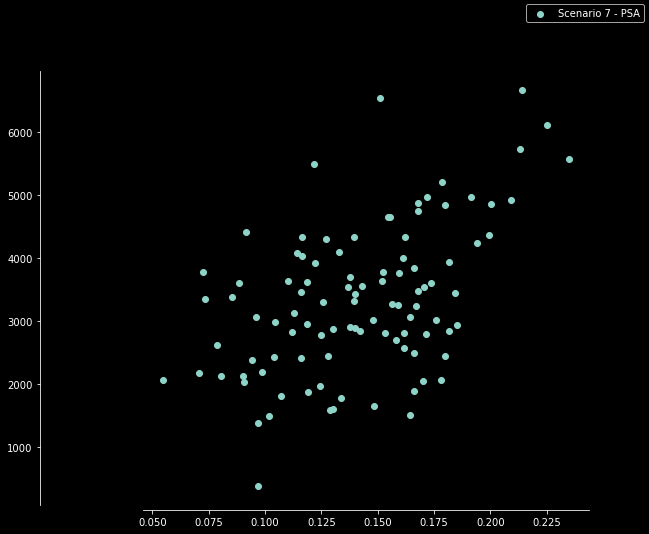

In [40]:
internal_reps_PSA = 25

[DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM, QALYS_rep_CUSUM, COSTS_rep_CUSUM] = LISLIS

plt.style.use("dark_background")

fig = plt.figure(figsize = (8,8))
ax = plt.axes()

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

#ax.xaxis.set_label_position('left')
#ax.yaxis.set_label_position('left')

#ax.set_xlabel('Incremental Effect (DALYs/$)')
#ax.set_ylabel('Incremental Cost ($)')
#ax.set_title('The incremental cost-effectiveness place - Scenario 1')

plt.scatter((np.array(DALYS_rep) - np.array(DALYS_rep_CUSUM))/(population_size*internal_reps_PSA), (np.array(COSTS_rep_CUSUM) - np.array(COSTS_rep))/(population_size*internal_reps_PSA))

#ax.set_xlim(-10, 10)
#ax.set_ylim(-10000, 10000)
fig.legend(['Scenario 7 - PSA'])
plt.show()

In [41]:
points_raw = list(zip((np.array(DALYS_rep) - np.array(DALYS_rep_CUSUM))/(population_size*internal_reps_PSA), (np.array(COSTS_rep_CUSUM) - np.array(COSTS_rep))/(population_size*internal_reps_PSA)))
lambdas = np.arange(150)*500
lambda_ceac = []
willing_points_list = []
unwilling_points_list = []

PSA_lambda_points = pd.DataFrame({})

points_no_NW = []
#NW points should be eliminated
for point in points_raw:
    if (point[0] < 0) & (point[1] > 0):
        None
    else:
        points_no_NW.append(point)

points = []
willing_points_initial = 0
#SW and SE points are already willing points
for point in points_no_NW:        
    if (point[0] < 0) & (point[1] < 0) | (point[0] > 0) & (point[1] < 0):
        willing_points_initial = willing_points_initial + 1
    else:
        points.append(point)
            
for lambdaa in lambdas:
        
    willing_points = willing_points_initial
    
    for point in points:
        if float(np.cross(point, [1,lambdaa])) >= 0: #the point is below the line : willing to pay for
            willing_points = willing_points + 1
    
    willing_points_list.append(willing_points)
        
PSA_lambda_points['lambda'] = lambdas
PSA_lambda_points['willing-points'] = willing_points_list
    
#________________________________________________________________________________________________________________________________________________________

PSA_lambda_points.to_csv('PSA_lambda_points_7.csv')


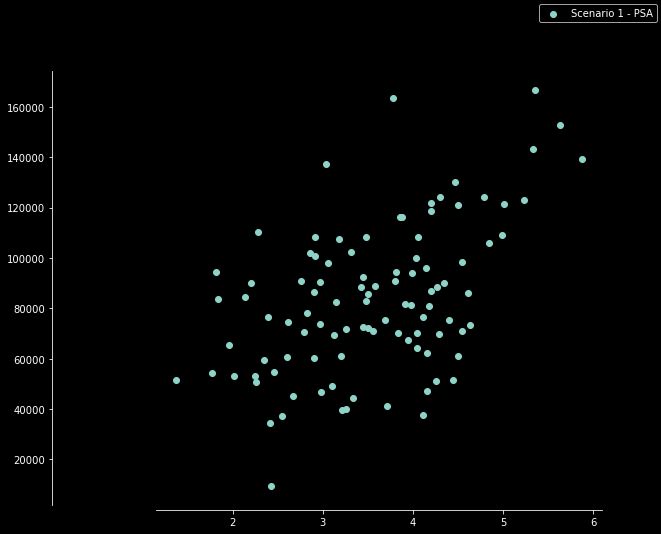

In [42]:
[DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM, QALYS_rep_CUSUM, COSTS_rep_CUSUM] = LISLIS

plt.style.use("dark_background")

fig = plt.figure(figsize = (8,8))
ax = plt.axes()

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

#ax.xaxis.set_label_position('left')
#ax.yaxis.set_label_position('left')

#ax.set_xlabel('Incremental Effect (DALYs/$)')
#ax.set_ylabel('Incremental Cost ($)')
#ax.set_title('The incremental cost-effectiveness place - Scenario 1')

plt.scatter((np.array(DALYS_rep) - np.array(DALYS_rep_CUSUM))/(population_size), (np.array(COSTS_rep_CUSUM) - np.array(COSTS_rep))/(population_size))

#ax.set_xlim(-10, 10)
#ax.set_ylim(-10000, 10000)
fig.legend(['Scenario 1 - PSA'])
plt.show()

Text(0.5, 1.0, 'Wiilingness To Pay (WTP)')

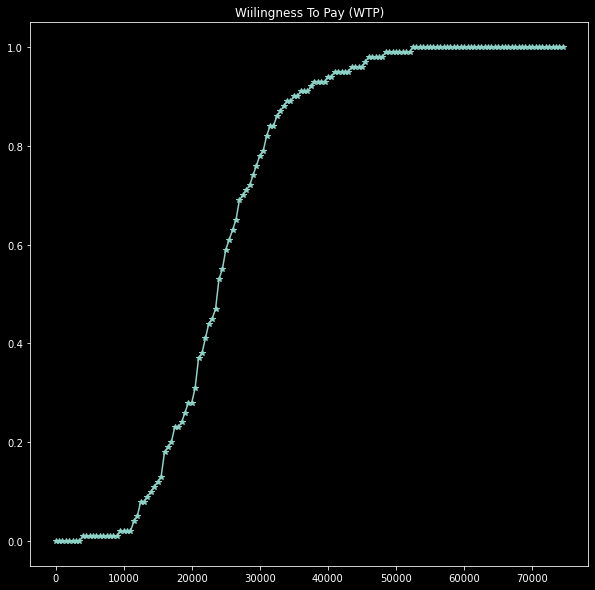

In [43]:
points = list(zip((np.array(DALYS_rep) - np.array(DALYS_rep_CUSUM))/(population_size), (np.array(COSTS_rep_CUSUM) - np.array(COSTS_rep))/(population_size)))
lambdas = np.arange(150)*500
lambda_ceac = []
willing_points_list = []
unwilling_points_list = []

PSA_lambda_points = pd.DataFrame({})

for lambdaa in lambdas:
    
    willing_points = 0
    unwilling_points = 0
    
    for point in points:
        if float(np.cross(point, [1,lambdaa])) >= 0: #the point is below the line : willing to pay for
            willing_points = willing_points + 1
        else:
            unwilling_points = unwilling_points + 1
    
    willing_points_list.append(willing_points)
    unwilling_points_list.append(unwilling_points)
    
    lambda_ceac.append((lambdaa, (willing_points/(willing_points + unwilling_points))))
    
PSA_lambda_points['lambda'] = lambdas
PSA_lambda_points['willing-points'] = willing_points_list
PSA_lambda_points['unwilling-points'] = unwilling_points_list

    
#________________________________________________________________________________________________________________________________________________________


plt.style.use("dark_background")

fig = plt.figure(figsize = (10,10))
ax = plt.axes()

plt.plot(*zip(*lambda_ceac), '-*')

#ax.set_xlim(-0.5, 70000)
#ax.set_ylim(-0.000001, 1)

ax.set_title('Wiilingness To Pay (WTP)')

In [44]:

with open("Base_PSA_Scenario_DALYS_rep.txt", "rb") as fp:   #Loading
    DALYS_rep = pickle.load(fp)
    
with open("Base_PSA_Scenario_QALYS_rep.txt", "rb") as fp:   #Loading
    QALYS_rep = pickle.load(fp)
    
with open("Base_PSA_Scenario_COSTS_rep.txt", "rb") as fp:   #Loading
    COSTS_rep = pickle.load(fp)


with open("Scenario_PSA_DALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    DALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_PSA_QALYS_rep_CUSUM.txt", "rb") as fp:   #Loading
    QALYS_rep_CUSUM_SA = pickle.load(fp)

with open("Scenario_PSA_COSTS_rep_CUSUM.txt", "rb") as fp:   #Loading
    COSTS_rep_CUSUM_SA = pickle.load(fp)
    

            
# Additional Dr. Chen thing: Do the total column thing right here:
             
LISLIS = [DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM_SA, QALYS_rep_CUSUM_SA, COSTS_rep_CUSUM_SA]

for lis in LISLIS:
    i = 0
    for para_lis in lis: #100 lists in each list

        final_col = 0
        for col in para_lis.columns:
            final_col = final_col + para_lis[col]/((1+0.03)**(int(col)-30))

        Total_things = np.sum(final_col)

        lis[i] = Total_things

        i = i +1     

        

internal_reps_PSA = 25

[DALYS_rep, QALYS_rep, COSTS_rep, DALYS_rep_CUSUM, QALYS_rep_CUSUM, COSTS_rep_CUSUM] = LISLIS



points = list(zip((np.array(DALYS_rep) - np.array(DALYS_rep_CUSUM))/(population_size), (np.array(COSTS_rep_CUSUM) - np.array(COSTS_rep))/(population_size)))
lambdas = np.arange(150)*500
lambda_ceac = []
willing_points_list = []
unwilling_points_list = []

PSA_lambda_points = pd.DataFrame({})

for lambdaa in lambdas:
    
    willing_points = 0
    unwilling_points = 0
    
    for point in points:
        if float(np.cross(point, [1,lambdaa])) >= 0: #the point is below the line : willing to pay for
            willing_points = willing_points + 1
        else:
            unwilling_points = unwilling_points + 1
    
    willing_points_list.append(willing_points)
    unwilling_points_list.append(unwilling_points)
    
    lambda_ceac.append((lambdaa, (willing_points/(willing_points + unwilling_points))))
    
PSA_lambda_points['lambda'] = lambdas
PSA_lambda_points['willing-points'] = willing_points_list
PSA_lambda_points['unwilling-points'] = unwilling_points_list

    
PSA_lambda_points.to_csv('PSA_lambda_points_2_w.csv')